In [23]:
import os
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import pearsonr
from sklearn.cluster import KMeans
import pandas as pd
from tqdm.notebook import tqdm
import plotly.express as px
from sqlalchemy import Text
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

load_dotenv()

True

1. Rausfinden unterschied wind und last
MUSS SEIN : WIND = LOAD
2. Y Achse: Variabilität (1.1 - 0.9)
    X Achso :spezifische beschaffungskosten (wind * preis ppa - (wind - load) * preis spot) / load
    geclustert für eine industrie (homogenität)
    
3.
    gemittelt über sektor (mittelwert über alle Kosten und spread (abstand zwischen 1.1 und 0.9 so dass wir nur noch einen wert pro sektor haben)) -> scatter
    
4.
    gemittelt über ort (nuts) wie zwei nur pro region

5. Eigennutzung bestimmen -> wahrscheinlich geringeres risiko

In [24]:
URI = os.getenv("URI")

In [3]:
load = pd.read_sql("""SELECT sum("value") AS total_load, "id" FROM vea_industrial_load_profiles.load GROUP BY "id" """, URI)
load

total_load    id
0     22703172.16     0
1      7332704.00     1
2      4548165.60     2
3      4012580.00     3
4     64842912.00     4
...           ...   ...
5354   9105507.00  5354
5355   8285980.00  5355
5356   6187080.00  5356
5357    423852.00  5357
5358    505399.08  5358

[5359 rows x 2 columns]

In [4]:
df = pd.read_sql("SELECT * FROM vea_industrial_load_profiles.master", URI)
df = df.merge(load, on="id")
df

id sector_group_id                                       sector_group  \
0        0               B                               Mining and quarrying   
1        1               B                               Mining and quarrying   
2        2               B                               Mining and quarrying   
3        3               B                               Mining and quarrying   
4        4               C                             Manufacturing industry   
...    ...             ...                                                ...   
5354  5354               C                             Manufacturing industry   
5355  5355               C                             Manufacturing industry   
5356  5356               H                     Transportation and warehousing   
5357  5357               C                             Manufacturing industry   
5358  5358               G  Trade, maintenance and repair of motor vehicle...   

      capacity_price_over_2500h_eur_per_kw  \
0                                    94.60   
1                                    96.11   
2                                    96.11   
3                                    96.11   
4                                   101.04   
...                                    ...   
5354                                131.29   
5355                                100.28   
5356                                 83.56   
5357                                 99.51   
5358                                 78.03   

      energy_price_over_2500h_eur_per_kwh  \
0                                  0.0060   
1                                  0.0052   
2                                  0.0052   
3                                  0.0052   
4                                  0.0078   
...                                   ...   
5354                               0.0041   
5355                               0.0157   
5356                               0.0081   
5357                               0.0057   
5358                               0.0075   

      capacity_price_under_2500h_eur_per_kw  \
0                                     14.67   
1                                      9.92   
2                                      9.92   
3                                      9.92   
4                                     12.60   
...                                     ...   
5354                                   8.37   
5355                                  23.81   
5356                                   7.72   
5357                                   5.95   
5358                                  14.40   

      energy_price_under_2500h_eur_per_kwh  zip_code grid_level  \
0                                   0.0379        85         MS   
1                                   0.0397        91         MS   
2                                   0.0397        92         MS   
3                                   0.0397        85         MS   
4                                   0.0432        30         MS   
...                                    ...       ...        ...   
5354                                0.0533         4         MS   
5355                                0.0463        24         MS   
5356                                0.0384        29         MS   
5357                                0.0433        66         MS   
5358                                0.0330        49      MS/NS   

      number_of_peak_load  ...  mean_load_kw    variance_kw  total_energy_kwh  \
0                       1  ...    646.151302  423413.418622        5675793.04   
1                       1  ...    208.694900  109792.561757        1833176.00   
2                       1  ...    129.444604   36662.220510        1137041.40   
3                       1  ...    114.201389   19954.089684        1003145.00   
4                       2  ...   1845.483607  610080.465591       16210728.00   
...                   ...  ...           ...            ...               ...   
5354

In [5]:
print(list(zip(df["sector_group_id"].unique(), df["sector_group"].unique())))
px.bar(df.groupby("sector_group_id", as_index=True).apply(len).sort_values(), title="Anzahl an Unternehmen nach Sektor im Datensatz")

[('B', 'Mining and quarrying'), ('C', 'Manufacturing industry'), ('Q', 'Health and social services'), ('L', 'Real estate and housing'), ('F', 'Construction'), ('G', 'Trade, maintenance and repair of motor vehicles and motorcycles'), ('J', 'Information technology'), (None, None), ('N', 'Provision of other business services'), ('R', 'Arts, entertainment and recreation'), ('K', 'Provision of financial and insurance services'), ('I', 'Hospitality'), ('E', 'Water supply, wastewater and waste disposal and removal of environmental pollution'), ('H', 'Transportation and warehousing'), ('O', 'Public administration, defense, social security'), ('S', 'Provision of other services'), ('M', 'Provision of freelance, scientific and technical services'), ('A', 'Agriculture, forestry and fishing'), ('P', 'Education and teaching'), ('D', 'Energy supply')]


In [8]:
results = pd.read_sql("""SELECT 
    aggregated.profile_id,
    aggregated.nuts_id, 
	aggregated.plz, 
    aggregated.total_market_value, 
    plz_data.latitude, 
    plz_data.longitude
FROM (
    SELECT 
        profile_id,
        nuts_id, 
		plz,
        SUM("market_value_single_turbine(€)") AS total_market_value
    FROM vea_results_timeseries.ppa_results
    GROUP BY profile_id, nuts_id, plz
) AS aggregated
JOIN (
    SELECT 
        AVG(longitude) AS longitude, 
        AVG(latitude) AS latitude, 
        substring(code::text, 0,3) AS code
    FROM public.plz
    GROUP BY substring(code::text, 0,3)
) AS plz_data
ON aggregated.plz = plz_data.code;
""", URI)

In [9]:
results

profile_id nuts_id plz  total_market_value   latitude  longitude
0             64   DEA15  41          130187.336  51.204720   7.740144
1           4641   DEA13  45          144724.890  51.468243   7.816018
2           4075   DE263  97           71228.086  49.933683   9.998957
3           3957   DEA13  45          144724.890  51.468243   7.816018
4           2154   DEA11  40          136013.300  51.235654   6.840076
...          ...     ...  ..                 ...        ...        ...
3293        4619   DEA44  33           96505.700  51.882100   8.579976
3294         151   DEA23  51          124756.250  50.989067   7.213336
3295        1844     DE6  22          134873.610  53.605056  10.084391
3296        4752   DE731  34           84190.270  51.255306   9.338845
3297        4855   DEA53  58          155443.310  51.316636   7.592746

[3298 rows x 6 columns]

In [10]:
# Visualisierung auf einer Karte von Deutschland
fig = px.scatter_mapbox(
    results,
    lat="latitude",  # Spalte für Breitengrad
    lon="longitude",  # Spalte für Längengrad
    hover_name="nuts_id",  # NUTS-ID als Tooltip anzeigen
    hover_data=["total_market_value"],  # Zusätzliche Informationen im Tooltip
    color="total_market_value",  # Farbskala basierend auf einem Wert (z. B. Marktwert)
    mapbox_style="carto-positron",  # Stil der Karte (z. B. Carto Positron)
    zoom=4,  # Zoom-Level für Deutschland
    center={"lat": 51.1657, "lon": 10.4515}  # Zentrum der Karte (Deutschland)
)
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 700,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
# Karte anzeigen
fig.show(config=config)

In [16]:
results = pd.read_sql("""SELECT 
    aggregated.profile_id,
    aggregated.nuts_id, 
	aggregated.plz, 
    aggregated.ppa_scenario_value, 
    plz_data.latitude, 
    plz_data.longitude
FROM (
    SELECT 
        profile_id,
        nuts_id, 
		plz,
        SUM("scenario_with_ppa_1.1(€)") -  SUM("scenario_as_is_0.9(€)") AS ppa_scenario_value
    FROM vea_results_timeseries.ppa_results
    GROUP BY profile_id, nuts_id, plz
) AS aggregated
JOIN (
    SELECT 
        AVG(longitude) AS longitude, 
        AVG(latitude) AS latitude, 
        substring(code::text, 0,3) AS code
    FROM public.plz
    GROUP BY substring(code::text, 0,3)
) AS plz_data
ON aggregated.plz = plz_data.code;
""", URI)

In [13]:
# Visualisierung auf einer Karte von Deutschland
fig = px.scatter_mapbox(
    results,
    lat="latitude",  # Spalte für Breitengrad
    lon="longitude",  # Spalte für Längengrad
    hover_name="nuts_id",  # NUTS-ID als Tooltip anzeigen
    hover_data=["ppa_scenario_value"],  # Zusätzliche Informationen im Tooltip
    color="ppa_scenario_value",  # Farbskala basierend auf einem Wert (z. B. Marktwert)
    mapbox_style="carto-positron",  # Stil der Karte (z. B. Carto Positron)
    zoom=4,  # Zoom-Level für Deutschland
    center={"lat": 51.1657, "lon": 10.4515}  # Zentrum der Karte (Deutschland)
)
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 700,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
# Karte anzeigen
fig.show(config=config)

In [17]:
# Visualisierung auf einer Karte von Deutschland
fig = px.scatter_mapbox(
    results,
    lat="latitude",  # Spalte für Breitengrad
    lon="longitude",  # Spalte für Längengrad
    hover_name="nuts_id",  # NUTS-ID als Tooltip anzeigen
    hover_data=["ppa_scenario_value"],  # Zusätzliche Informationen im Tooltip
    color="ppa_scenario_value",  # Farbskala basierend auf einem Wert (z. B. Marktwert)
    mapbox_style="carto-positron",  # Stil der Karte (z. B. Carto Positron)
    zoom=4,  # Zoom-Level für Deutschland
    center={"lat": 51.1657, "lon": 10.4515}  # Zentrum der Karte (Deutschland)
)
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 700,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
# Karte anzeigen
fig.show(config=config)

In [19]:
all_results = pd.read_sql("""SELECT 
    *
FROM 
    vea_results_timeseries.ppa_results AS ppa_results""", URI)

In [22]:
all_results.columns

Index(['timestamp', 'wind_speed', 'roughness_length', 'Actual Power (W)',
       'price', 'Actual Power (MWh)', 'Market Value (€)', 'Load (kWh)',
       'Load (MWh)', 'PPA Surplus (MWh)', 'Scenario As Is (€)',
       'Scenario With PPA (€)', 'plz', 'nuts_id', 'profile_id',
       'sector_group_id', 'sector_group'],
      dtype='object')

In [15]:
load_per_sector_per_month = pd.read_sql("""SELECT 
    time_bucket('1 month', timestamp) AS month,
	sector_group,
    sum("load(mwh)") AS load,
    avg("wind_speed") AS wind_speed
FROM vea_results_timeseries.ppa_results
GROUP BY month, sector_group
ORDER BY month;""", URI)

In [24]:
fig = px.density_heatmap(
    load_per_sector_per_month,
    x='month',
    y='sector_group',
    z='load',
    color_continuous_scale='Viridis',
    title='Monatlicher Energieverbrauch nach Sektor',
    labels={'month': 'Monat', 'sector_group': 'Sektor', 'load': 'Energieverbrauch (MWh)'}
)

fig.show()

In [26]:
all_results.head(2)

timestamp  wind_speed  roughness_length  Actual Power (W)  price  \
0 2019-01-01 00:00:00    3.962557              0.03         951741.25  10.07   
1 2019-01-01 01:00:00    4.231980              0.03        1199079.10  -4.08   

   Actual Power (MWh)  Market Value (€)  Load (kWh)  Load (MWh)  \
0            0.951741          9.584034        38.0      0.0380   
1            1.199079         -4.892242        39.8      0.0398   

   PPA Surplus (MWh)  Scenario As Is (€)  Scenario With PPA (€) plz nuts_id  \
0           0.913741            0.382660              16.393564  46   DEA17   
1           1.159279           -0.162384              36.976390  46   DEA17   

   profile_id sector_group_id            sector_group  
0          10               C  Manufacturing industry  
1          10               C  Manufacturing industry

In [16]:
# ------------------------------
# KORRELATIONSANALYSE
# ------------------------------
# Berechne die Korrelation zwischen Windgeschwindigkeit und Last pro Sektor
correlation_results = load_per_sector_per_month.groupby('sector_group').apply(
    lambda x: pd.Series({
        'correlation': pearsonr(x['wind_speed'], x['load'])[0],
        'p_value': pearsonr(x['wind_speed'], x['load'])[1]
    })
).reset_index()

print("Korrelationsanalyse:")
print(correlation_results)

Korrelationsanalyse:
                                         sector_group  correlation   p_value
0                   Agriculture, forestry and fishing     0.076489  0.813226
1                  Arts, entertainment and recreation    -0.454626  0.137580
2                                        Construction     0.429241  0.163776
3                              Education and teaching    -0.281180  0.375979
4                                       Energy supply    -0.415902  0.178723
5                          Health and social services    -0.509948  0.090313
6                                         Hospitality    -0.621022  0.031148
7                              Information technology    -0.426833  0.166414
8                              Manufacturing industry    -0.410254  0.185299
9                                Mining and quarrying    -0.444379  0.147803
10      Provision of financial and insurance services    -0.550397  0.063695
11  Provision of freelance, scientific and technic...  

In [17]:
fig_correlation = px.bar(
    correlation_results,
    x='sector_group',
    y='correlation',
    title='Korrelationsanalyse: Windgeschwindigkeit vs. Last pro Sektor',
    labels={'sector_group': 'Sektor', 'correlation': 'Korrelationskoeffizient'},
    text='correlation'
)
fig_correlation.show()

In [18]:
# ------------------------------
# CLUSTERANALYSE
# ------------------------------
# Vorbereitung der Daten für das Clustering
X = load_per_sector_per_month[['load', 'wind_speed']].values

# Führe KMeans-Clustering durch (2 Cluster als Beispiel)
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
load_per_sector_per_month['cluster'] = kmeans.fit_predict(X)

print("Clusteranalyse:")
print(load_per_sector_per_month[['sector_group', 'month', 'load', 'wind_speed', 'cluster']])


Clusteranalyse:
                                          sector_group      month        load  \
0                    Agriculture, forestry and fishing 2019-01-01  2712.96750   
1                   Arts, entertainment and recreation 2019-01-01   563.05255   
2                                         Construction 2019-01-01  1282.73080   
3                               Education and teaching 2019-01-01   793.94147   
4                                        Energy supply 2019-01-01   135.47290   
..                                                 ...        ...         ...   
235                            Real estate and housing 2019-12-01   998.51080   
236  Trade, maintenance and repair of motor vehicle... 2019-12-01  8997.02000   
237                     Transportation and warehousing 2019-12-01  6245.74900   
238  Water supply, wastewater and waste disposal an... 2019-12-01  2905.18120   
239                                               None 2019-12-01  6993.47800   

     wind_s

In [19]:
# Visualisierung der Cluster mit Plotly Express
fig_clusters = px.scatter(
    load_per_sector_per_month,
    x='wind_speed',
    y='load',
    color='cluster',
    symbol='sector_group',
    title='Clusteranalyse: Windgeschwindigkeit vs. Last',
    labels={'wind_speed': 'Durchschnittliche Windgeschwindigkeit (m/s)', 
            'load': 'Durchschnittliche Last (MWh)', 
            'cluster': 'Cluster'},
    hover_data=['month', 'sector_group']
)
fig_clusters.show()

In [3]:
mismatch_data = pd.read_sql("""SELECT
    profile_id,
    ROUND(SUM("scenario_as_is_1(€)")::numeric, 2) AS scenario_as_is,
    ROUND(SUM("scenario_with_ppa_1(€)")::numeric, 2) AS scenario_ppa,
    ROUND((SUM("scenario_as_is_1(€)")::numeric - SUM("scenario_with_ppa_1(€)")::numeric), 2) AS difference
FROM vea_results_timeseries.ppa_results
GROUP BY profile_id
HAVING ROUND(SUM("scenario_as_is_1(€)")::numeric, 2) <> ROUND(SUM("scenario_with_ppa_1(€)")::numeric, 2)
ORDER BY difference DESC;
""", URI)

array([[<Axes: title={'center': 'difference'}>]], dtype=object)

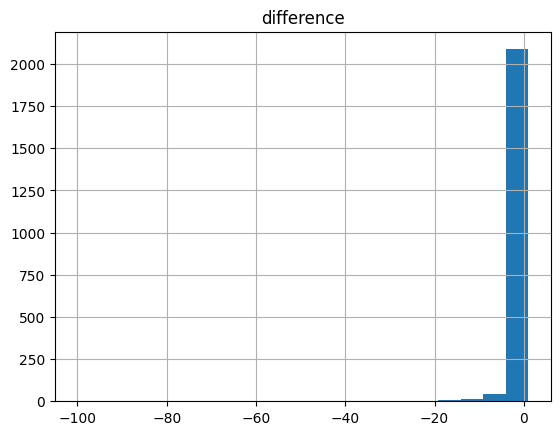

In [4]:
mismatch_data.hist(column='difference', bins=20)

In [5]:
len(mismatch_data)

2152

In [26]:
spread = pd.read_sql("""SELECT
    profile_id,
    nuts_id,
    ROUND((SUM("scenario_as_is_1(€)")::numeric - SUM("scenario_with_ppa_1(€)")::numeric), 2) AS difference_1,
    ROUND((SUM("scenario_as_is_1.1(€)")::numeric - SUM("scenario_as_is_0.9(€)")::numeric), 2) AS difference_as_is,
    ROUND((SUM("scenario_with_ppa_1.1(€)")::numeric - SUM("scenario_with_ppa_0.9(€)")::numeric), 2) AS difference_with_ppa
FROM vea_results_timeseries.ppa_results
WHERE sector_group_id = 'A'
GROUP BY profile_id, nuts_id
""", URI)

array([[<Axes: title={'center': 'difference_1'}>]], dtype=object)

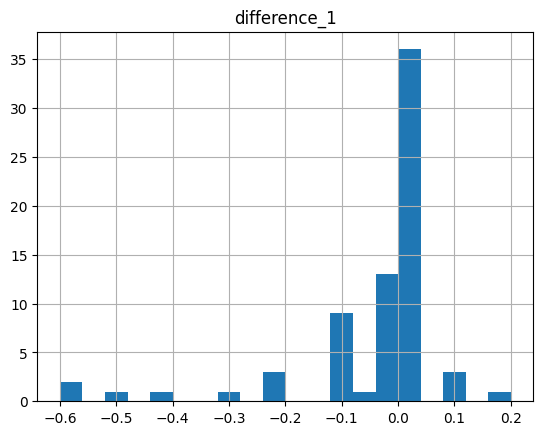

In [27]:
spread.hist(column='difference_1', bins=20)

array([[<Axes: title={'center': 'difference_as_is'}>]], dtype=object)

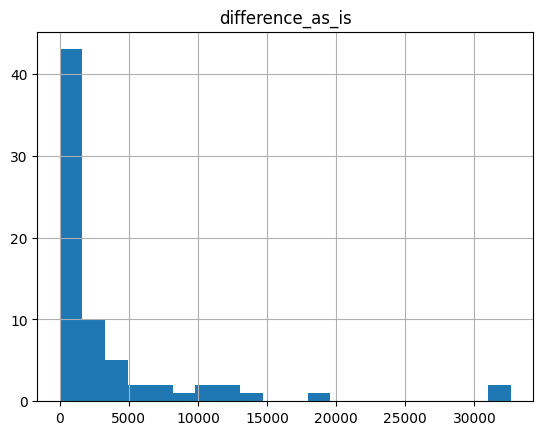

In [28]:
spread.hist(column='difference_as_is', bins=20)

array([[<Axes: title={'center': 'difference_with_ppa'}>]], dtype=object)

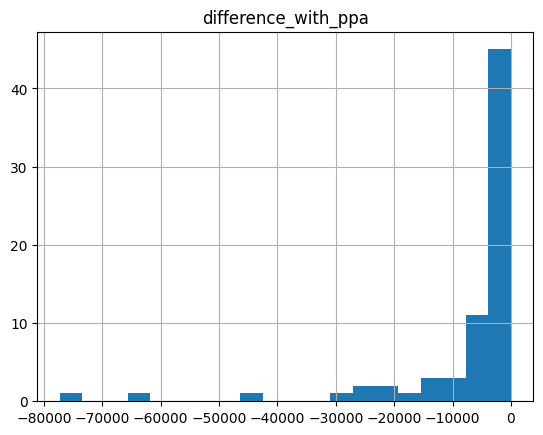

In [29]:
spread.hist(column='difference_with_ppa', bins=20)

In [82]:
spread = pd.read_sql("""
SELECT
    aggregated.profile_id,
    aggregated.nuts_id,
    aggregated.difference_as_is,
    aggregated.difference_with_ppa,
    aggregated.scenario_as_is_1,
    aggregated.scenario_with_ppa_1,
    plz_data.latitude,
    plz_data.longitude
FROM (
    SELECT
        profile_id,
        nuts_id,
        plz,
        SUM("scenario_as_is_1(€)") AS scenario_as_is_1,
        SUM("scenario_with_ppa_1(€)") AS scenario_with_ppa_1,
        ROUND(((SUM("scenario_as_is_1.1(€)")::numeric - SUM("scenario_as_is_0.9(€)")::numeric)) / SUM("scenario_as_is_1(€)")::numeric, 3) AS difference_as_is,
        ROUND(((SUM("scenario_with_ppa_1.1(€)")::numeric - SUM("scenario_with_ppa_0.9(€)")::numeric)) / SUM("scenario_with_ppa_1(€)")::numeric, 3) AS difference_with_ppa
    FROM vea_results_timeseries.ppa_results
    WHERE sector_group_id = 'A'
    GROUP BY profile_id, nuts_id, plz
) AS aggregated
JOIN (
    SELECT 
        AVG(longitude) AS longitude, 
        AVG(latitude) AS latitude, 
        substring(code::text, 0,3) AS code
    FROM public.plz
    GROUP BY substring(code::text, 0,3)
) AS plz_data
ON aggregated.plz = plz_data.code;
""", URI)


In [83]:
spread = spread.groupby('nuts_id').mean()
spread = spread.reset_index()

In [85]:
spread_melted = spread.melt(
    id_vars=["nuts_id"],
    value_vars=["difference_as_is", "difference_with_ppa"],
    var_name="Difference Type",
    value_name="Value"
)

# Balkendiagramm erstellen
fig = px.bar(
    spread_melted,
    x="nuts_id",
    y="Value",
    color="Difference Type",
    barmode="group",
    title="Verteilung der Differenzen nach NUTS-ID"
)

fig.show()

In [87]:
# Visualisierung auf einer Karte von Deutschland
fig = px.scatter_mapbox(
    spread,
    lat="latitude",  # Spalte für Breitengrad
    lon="longitude",  # Spalte für Längengrad
    hover_name="nuts_id",  # NUTS-ID als Tooltip anzeigen
    hover_data=["difference_as_is", "difference_with_ppa"],  # Zusätzliche Informationen im Tooltip
    color="difference_with_ppa",  # Farbskala basierend auf einem Wert (z. B. Marktwert)
    mapbox_style="carto-positron",  # Stil der Karte (z. B. Carto Positron)
    zoom=4,  # Zoom-Level für Deutschland
    center={"lat": 51.1657, "lon": 10.4515}  # Zentrum der Karte (Deutschland)
)
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 700,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
# Karte anzeigen
fig.show(config=config)

In [3]:
spread = pd.read_sql("""
SELECT
    aggregated.profile_id,
    aggregated.nuts_id,
    aggregated."scenario_as_is_0.9",
    aggregated."scenario_as_is_0.95",
    aggregated."scenario_as_is_0.98",
    aggregated."scenario_as_is_1",
    aggregated."scenario_as_is_1.02",
    aggregated."scenario_as_is_1.05",
    aggregated."scenario_as_is_1.1",
    aggregated."scenario_with_ppa_0.9",
    aggregated."scenario_with_ppa_0.95",
    aggregated."scenario_with_ppa_0.98",
    aggregated."scenario_with_ppa_1",
    aggregated."scenario_with_ppa_1.02",
    aggregated."scenario_with_ppa_1.05",
    aggregated."scenario_with_ppa_1.1",
    plz_data.latitude,
    plz_data.longitude
FROM (
    SELECT
        profile_id,
        nuts_id,
        plz,
        SUM("scenario_as_is_0.9(€)") / SUM("load(mwh)") AS "scenario_as_is_0.9",
        SUM("scenario_as_is_0.95(€)") / SUM("load(mwh)") AS "scenario_as_is_0.95",
        SUM("scenario_as_is_0.98(€)") / SUM("load(mwh)") AS "scenario_as_is_0.98",
        SUM("scenario_as_is_1(€)") / SUM("load(mwh)") AS "scenario_as_is_1",
        SUM("scenario_as_is_1.02(€)") / SUM("load(mwh)") AS "scenario_as_is_1.02",
        SUM("scenario_as_is_1.05(€)") / SUM("load(mwh)") AS "scenario_as_is_1.05",
        SUM("scenario_as_is_1.1(€)") / SUM("load(mwh)") AS "scenario_as_is_1.1",
        SUM("scenario_with_ppa_0.9(€)") / SUM("load(mwh)") AS "scenario_with_ppa_0.9",
        SUM("scenario_with_ppa_0.95(€)") / SUM("load(mwh)") AS "scenario_with_ppa_0.95",
        SUM("scenario_with_ppa_0.98(€)") / SUM("load(mwh)") AS "scenario_with_ppa_0.98",
        SUM("scenario_with_ppa_1(€)") / SUM("load(mwh)") AS "scenario_with_ppa_1",
        SUM("scenario_with_ppa_1.02(€)") / SUM("load(mwh)") AS "scenario_with_ppa_1.02",
        SUM("scenario_with_ppa_1.05(€)") / SUM("load(mwh)") AS "scenario_with_ppa_1.05",
        SUM("scenario_with_ppa_1.1(€)") / SUM("load(mwh)") AS "scenario_with_ppa_1.1"
    FROM vea_results_timeseries.ppa_results
    WHERE sector_group_id = 'A'
    GROUP BY profile_id, nuts_id, plz
) AS aggregated
JOIN (
    SELECT 
        AVG(longitude) AS longitude, 
        AVG(latitude) AS latitude, 
        substring(code::text, 0,3) AS code
    FROM public.plz
    GROUP BY substring(code::text, 0,3)
) AS plz_data
ON aggregated.plz = plz_data.code;
""", URI)


In [4]:
spread

profile_id nuts_id  scenario_as_is_0.9  scenario_as_is_0.95  \
0          329    DEA3           33.454470            35.313007   
1          330   DEA17           32.726463            34.544560   
2          331   DE212           33.363720            35.217197   
3          332   DE212           32.928707            34.758213   
4          333   DE212           32.759323            34.579330   
5          544   DEE03           33.771760            35.647995   
6          898   DE713           33.853794            35.734673   
7          925   DEF02           34.424976            36.337390   
8         1115   DE929           33.881200            35.763496   
9         1210    DE91           33.958130            35.844612   
10        1211    DE91           35.741817            37.727493   
11        1283   DE222           33.740410            35.614800   
12        1405   DEA44           34.605225            36.527637   
13        1452   DEA44           34.256916            36.160053   
14        1453    DEA3           33.755240            35.630493   
15        1458   DE712           34.754364            36.685184   
16        1459   DE712           34.272457            36.176480   
17        1460   DE712           34.384598            36.294830   
18        1461   DE712           35.646305            37.626690   
19        1462   DE712           34.058430            35.950554   
20        1463   DE712           34.044823            35.936234   
21        1464   DE712           33.556510            35.420680   
22        1500   DEG04           34.225044            36.126545   
23        1502   DE944           33.741184            35.615788   
24        1503   DE300           34.153004            36.050316   
25        1888   DE944           33.990030            35.878296   
26        1973    DE91           32.417534            34.218513   
27        2133   DE263           34.560772            36.480827   
28        2177   DE147           34.456330            36.370610   
29        2223   DE944           34.111840            36.006920   
30        2236   DE212           34.206100            36.106453   
31        2380   DE929           35.115868            37.066765   
32        2452   DE300           33.982500            35.870500   
33        2500   DE944           34.456387            36.370552   
34        2547   DE212           33.599480            35.466164   
35        2981   DEA44           34.368910            36.278300   
36        3388   DE212           34.457054            36.371400   
37        3393   DE944           33.278194            35.127070   
38        3395   DEE03           33.523310            35.385710   
39        3519     DE6           32.714670            34.532160   
40        3547   DE232           33.874140            35.756138   
41        3766   DE222           32.746030            34.565247   
42        3935   DE212           34.754166            36.685043   
43        4028   DEA44           33.990370            35.878662   
44        4060   DE944           33.740580            35.615124   
45        4065   DEG04           33.767582            35.643757   
46        4135   DE713           34.902794            36.841770   
47        4555   DEF03           35.626392            37.605570   
48        4672   DEB11           34.065342            35.957832   
49        4741   DE263           33.913475            35.797592   
50        4814   DE929           33.802970            35.681007   
51        4830   DE944           34.036263            35.927063   
52        4996   DEA17           33.937250            35.822710   
53        5122   DE271           34.306683            36.212765   
54        5243   DEG01           34.718067            36.646885   
55        5345   DE300           36.733723            38.774480   

    scenario_as_is_0.98  scenario_as_is_1  scenario_as_is_1.02  \
0             36.428190         37.171623            37.915005   
1             35.635437         36.362750           

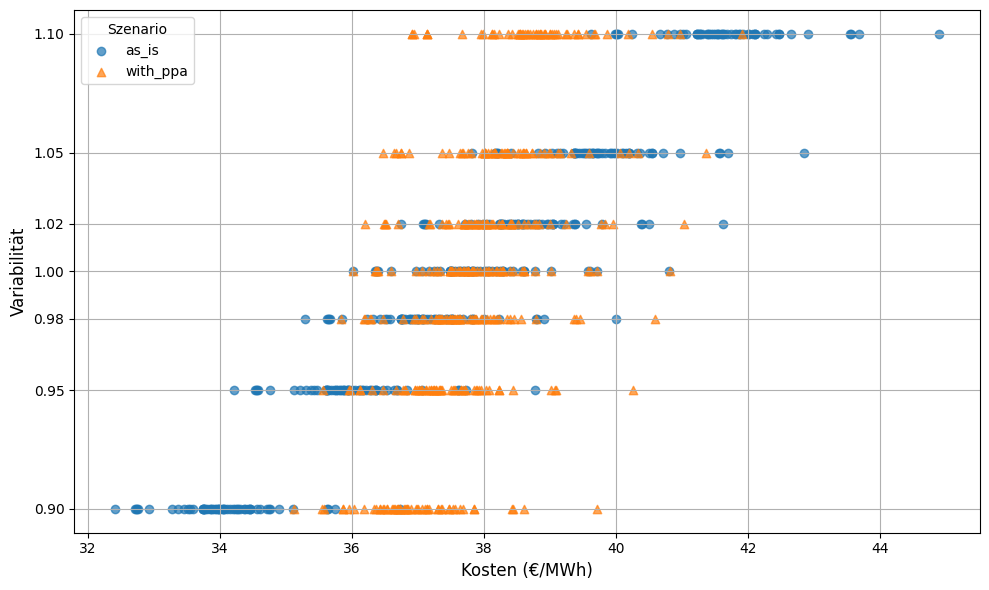

In [105]:
scenarios = ['as_is', 'with_ppa']
variabilities = [0.9, 0.95, 0.98, 1, 1.02, 1.05, 1.1]

# Daten für das Plotten vorbereiten
plot_data = []
for scenario in scenarios:
    for var in variabilities:
        cost_col = f'scenario_{scenario}_{var}'
        temp_df = spread[[cost_col]].copy()
        temp_df['Scenario'] = scenario
        temp_df['Variability'] = var
        temp_df.columns = ['Cost', 'Scenario', 'Variability']
        plot_data.append(temp_df)

# Alle DataFrames zusammenfügen
plot_df = pd.concat(plot_data, ignore_index=True)

# Symbole für Szenarien definieren
symbols = {'as_is': 'o', 'with_ppa': '^'}

# Streudiagramm erstellen
plt.figure(figsize=(10, 6))
for scenario in scenarios:
    scenario_data = plot_df[plot_df['Scenario'] == scenario]
    plt.scatter(
        scenario_data['Cost'],
        scenario_data['Variability'],
        label=scenario,
        marker=symbols[scenario],
        alpha=0.7
    )

# Diagramm formatieren
plt.xlabel("Kosten (€/MWh)", fontsize=12)
plt.ylabel("Variabilität", fontsize=12)
plt.legend(title="Szenario")
plt.grid(True)

# Y-Achse explizit auf die gewünschten Werte setzen
plt.yticks([0.9, 0.95, 0.98, 1, 1.02, 1.05, 1.1])

plt.tight_layout()

# Diagramm anzeigen
plt.show()

<Figure size 1200x600 with 0 Axes>

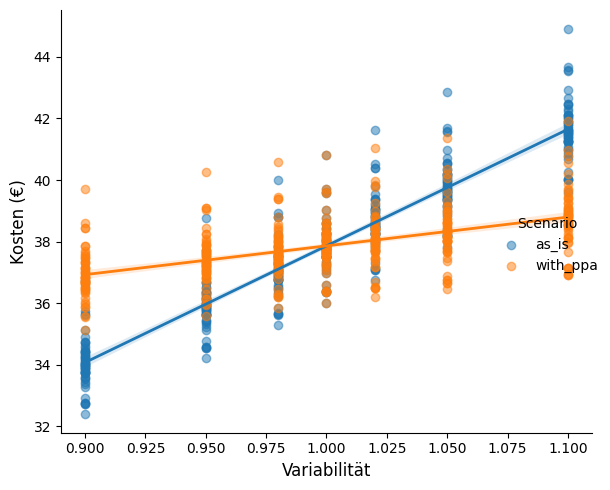

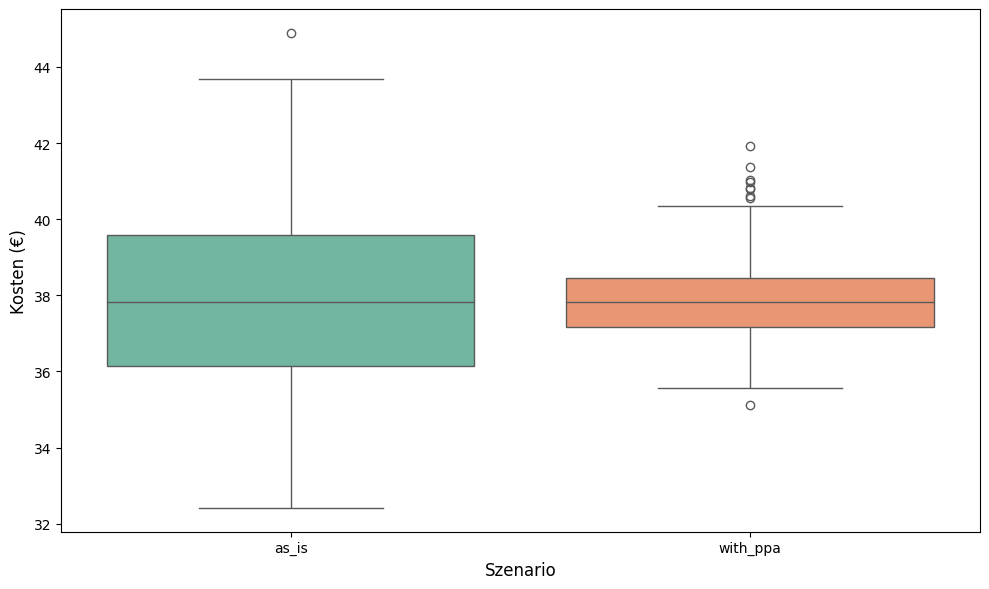

               Cost                                 Variability
               mean       std        min        max       count
Scenario                                                       
as_is     37.861354  2.458649  32.417576  44.896750         392
with_ppa  37.861383  1.038985  35.122086  41.914062         392


In [113]:
# Szenarien und Variabilitäten definieren
scenarios = ['as_is', 'with_ppa']
variabilities = [0.9, 0.95, 0.98, 1, 1.02, 1.05, 1.1]

# Daten für das Plotten vorbereiten
plot_data = []
for scenario in scenarios:
    for var in variabilities:
        cost_col = f'scenario_{scenario}_{var}'
        temp_df = spread[[cost_col]].copy()
        temp_df['Scenario'] = scenario
        temp_df['Variability'] = var
        temp_df.columns = ['Cost', 'Scenario', 'Variability']
        plot_data.append(temp_df)

# Alle DataFrames zusammenfügen
plot_df = pd.concat(plot_data, ignore_index=True)

# --- Regression mit Konfidenzintervall ---
plt.figure(figsize=(12, 6))
sns.lmplot(
    x='Variability', 
    y='Cost', 
    hue='Scenario', 
    data=plot_df, 
    ci=95,  # 95%-Konfidenzintervall
    scatter_kws={'alpha': 0.5},
    line_kws={'linewidth': 2}
)
plt.xlabel('Variabilität', fontsize=12)
plt.ylabel('Kosten (€)', fontsize=12)
plt.tight_layout()
plt.show()

# --- Boxplot für Kostenverteilung ---
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Scenario', 
    y='Cost', 
    data=plot_df,
    palette="Set2"
)
plt.xlabel('Szenario', fontsize=12)
plt.ylabel('Kosten (€)', fontsize=12)
plt.tight_layout()
plt.show()

# Statistische Zusammenfassung der Streuung
summary_stats = plot_df.groupby('Scenario').agg({
    'Cost': ['mean', 'std', 'min', 'max'],
    'Variability': ['count']
})
print(summary_stats)

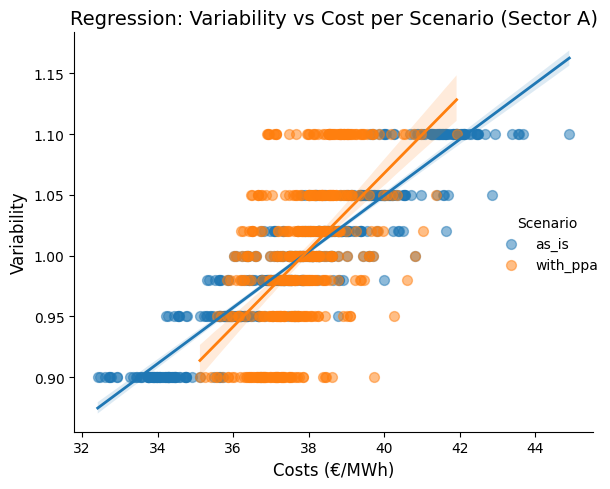

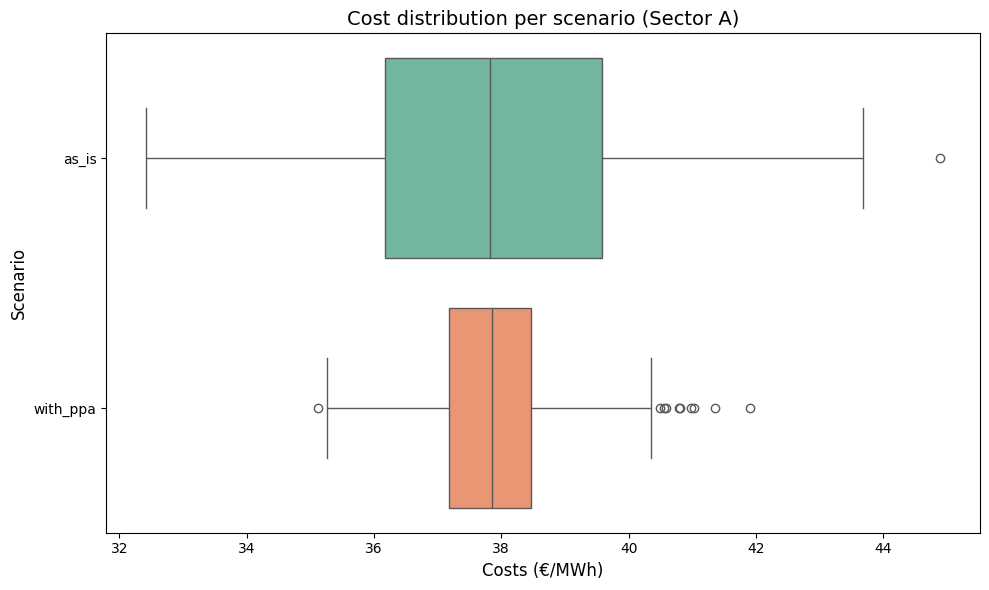

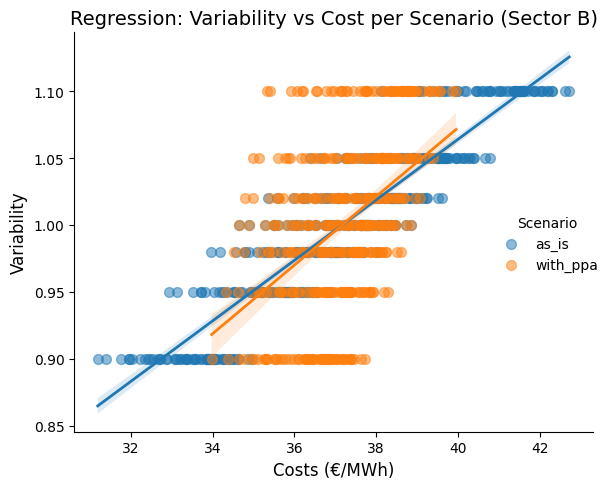

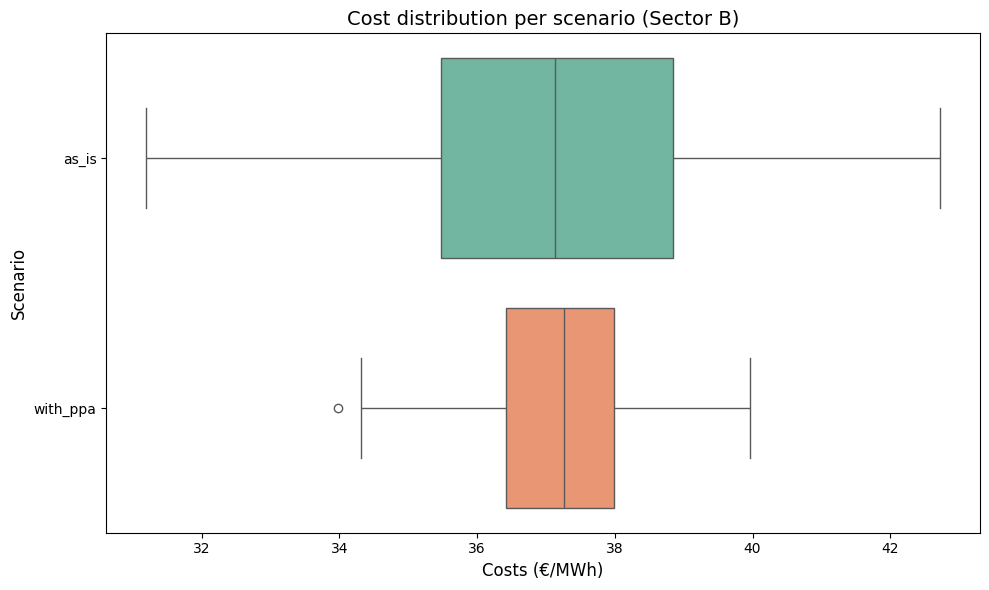

In [ ]:
# Definiere die Sektorgruppe IDs (A bis S)
sector_group_ids = [chr(i) for i in range(ord('A'), ord('S') + 1)]

# Szenarien und Variabilitäten definieren
scenarios = ['as_is', 'with_ppa']
variabilities = [0.9, 0.95, 0.98, 1, 1.02, 1.05, 1.1]

for sector_id in sector_group_ids:
    # SQL-Abfrage dynamisch anpassen
    query = f"""
    SELECT
        profile_id,
        nuts_id,
        plz,
        SUM("scenario_as_is_0.9(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_as_is_0.9",
        SUM("scenario_as_is_0.95(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_as_is_0.95",
        SUM("scenario_as_is_0.98(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_as_is_0.98",
        SUM("scenario_as_is_1(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_as_is_1",
        SUM("scenario_as_is_1.02(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_as_is_1.02",
        SUM("scenario_as_is_1.05(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_as_is_1.05",
        SUM("scenario_as_is_1.1(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_as_is_1.1",
        SUM("scenario_with_ppa_0.9(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_with_ppa_0.9",
        SUM("scenario_with_ppa_0.95(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_with_ppa_0.95",
        SUM("scenario_with_ppa_0.98(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_with_ppa_0.98",
        SUM("scenario_with_ppa_1(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_with_ppa_1",
        SUM("scenario_with_ppa_1.02(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_with_ppa_1.02",
        SUM("scenario_with_ppa_1.05(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_with_ppa_1.05",
        SUM("scenario_with_ppa_1.1(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_with_ppa_1.1"
    FROM vea_results_timeseries.ppa_results
    WHERE sector_group_id = '{sector_id}'
    GROUP BY profile_id, nuts_id, plz
    """

    # Daten aus der Datenbank abrufen
    try:
        spread = pd.read_sql(query, URI)
    except Exception as e:
        print(e)
        continue

    # Daten für das Plotten vorbereiten
    plot_data = []
    for scenario in scenarios:
        for var in variabilities:
            cost_col = f'scenario_{scenario}_{var}'
            temp_df = spread[[cost_col]].copy()
            temp_df['Scenario'] = scenario
            temp_df['Variability'] = var
            temp_df.columns = ['Cost', 'Scenario', 'Variability']
            plot_data.append(temp_df)

    # Alle DataFrames zusammenfügen
    plot_df = pd.concat(plot_data, ignore_index=True)

    # --- Regression mit Konfidenzintervall ---
    sns.lmplot(
        x='Cost', 
        y='Variability', 
        hue='Scenario', 
        data=plot_df, 
        ci=95,
        scatter_kws={'alpha': 0.5},
        line_kws={'linewidth': 2},
        x_estimator=np.median
    )
    plt.title(f'Regression: Variability vs Cost per Scenario (Sector {sector_id})', fontsize=14)
    plt.xlabel('Costs (€/MWh)', fontsize=12)
    plt.ylabel('Variability', fontsize=12)
    plt.tight_layout()
    plt.show()

    # --- Boxplot für Kostenverteilung ---
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x='Cost', 
        y='Scenario', 
        data=plot_df,
        palette="Set2"
    )
    plt.title(f'Cost distribution per scenario (Sector {sector_id})', fontsize=14)
    plt.xlabel('Costs (€/MWh)', fontsize=12)
    plt.ylabel('Scenario', fontsize=12)
    plt.tight_layout()
    plt.show()


# gemittelt über sektor (mittelwert über alle Kosten und spread (abstand zwischen 1.1 und 0.9 so dass wir nur noch einen wert pro sektor haben)) -> scatter

In [138]:
# SQL-Abfrage, um die Spreads zu berechnen
query = """
SELECT
    sector_group_id,
    mean_cost,
    "scenario_as_is_1.1" - "scenario_as_is_0.9" AS as_is_spread,
    "scenario_with_ppa_1.1" - "scenario_with_ppa_0.9" AS with_ppa_spread
FROM (
    SELECT
        sector_group_id,
        SUM("scenario_as_is_1(€)") AS "mean_cost",
        SUM("scenario_as_is_0.9(€)") AS "scenario_as_is_0.9",
        SUM("scenario_as_is_1.1(€)") AS "scenario_as_is_1.1",
        SUM("scenario_with_ppa_0.9(€)") AS "scenario_with_ppa_0.9",
        SUM("scenario_with_ppa_1.1(€)") AS "scenario_with_ppa_1.1"
    FROM vea_results_timeseries.ppa_results
    GROUP BY sector_group_id
) AS aggregated
GROUP BY sector_group_id;
"""

spread_df = pd.read_sql(query, URI)

# Vorbereitung der Daten für den Scatter Plot
# As-is Daten
as_is_data = spread_df[['sector_group_id', 'as_is_spread']].copy()
as_is_data['scenario'] = 'as_is'
as_is_data.columns = ['sector_group_id', 'spread', 'scenario']

# With PPA Daten
with_ppa_data = spread_df[['sector_group_id', 'with_ppa_spread']].copy()
with_ppa_data['scenario'] = 'with_ppa'
with_ppa_data.columns = ['sector_group_id', 'spread', 'scenario']

# Kombiniere die Daten
plot_df = pd.concat([as_is_data, with_ppa_data], ignore_index=True)


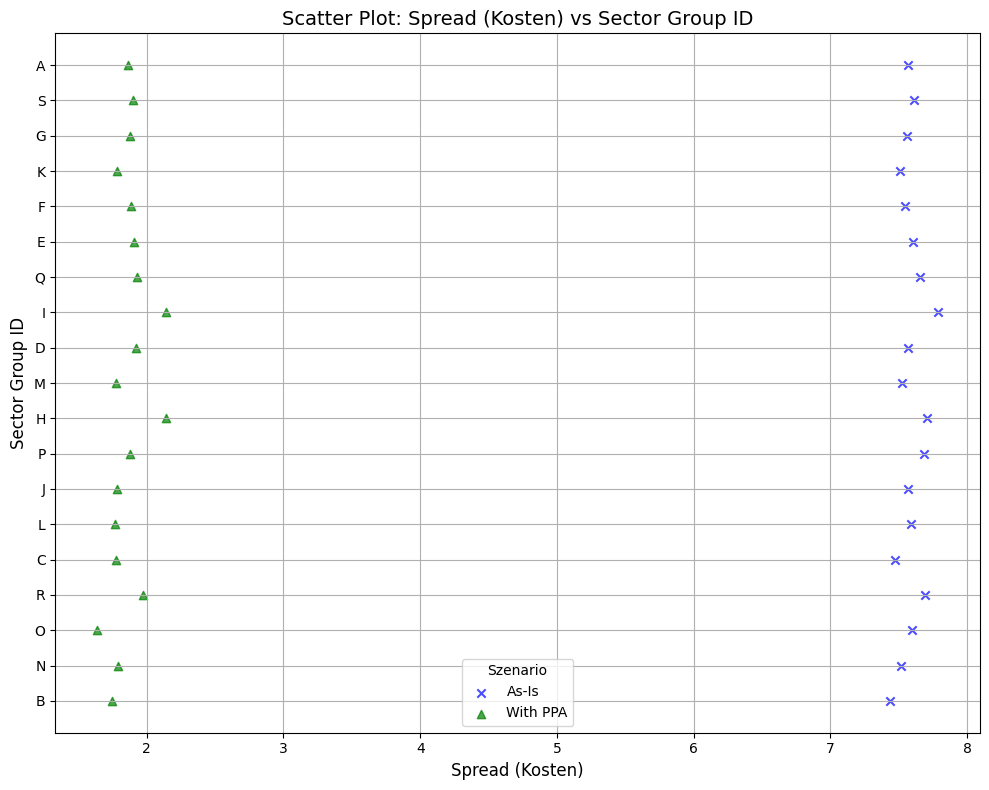

In [139]:
# Entferne Zeilen mit NaN-Werten
plot_df_cleaned = plot_df.dropna()

# Überprüfen Sie die bereinigte DataFrame

plt.figure(figsize=(10, 8))

# Plot für as-is (x-Symbol)
plt.scatter(
    plot_df_cleaned.loc[plot_df_cleaned['scenario'] == 'as_is', 'spread'],
    plot_df_cleaned.loc[plot_df_cleaned['scenario'] == 'as_is', 'sector_group_id'],
    label='As-Is',
    color='blue',
    marker='x',
    alpha=0.7
)

# Plot für with PPA (^ Symbol)
plt.scatter(
    plot_df_cleaned.loc[plot_df_cleaned['scenario'] == 'with_ppa', 'spread'],
    plot_df_cleaned.loc[plot_df_cleaned['scenario'] == 'with_ppa', 'sector_group_id'],
    label='With PPA',
    color='green',
    marker='^',
    alpha=0.7
)

# Achsen und Titel formatieren
plt.title('Scatter Plot: Spread (Kosten) vs Sector Group ID', fontsize=14)
plt.xlabel('Spread (Kosten)', fontsize=12)
plt.ylabel('Sector Group ID', fontsize=12)
plt.legend(title='Szenario')
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

X mittlere Kosten und danach Eigenversorgungsquote
Y Spread

# gemittelt über ort (nuts) wie zwei nur pro region

In [148]:
nuts_ids=pd.read_sql("""SELECT DISTINCT(nuts_id) FROM vea_results_timeseries.ppa_results""", URI)
nuts_ids=nuts_ids['nuts_id'].tolist()

DE12


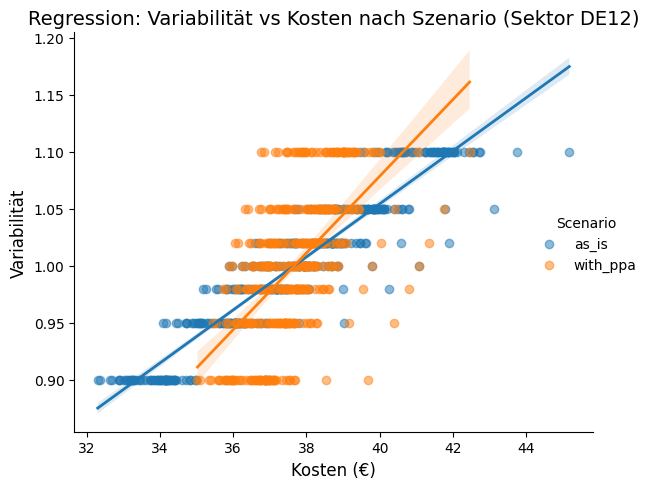

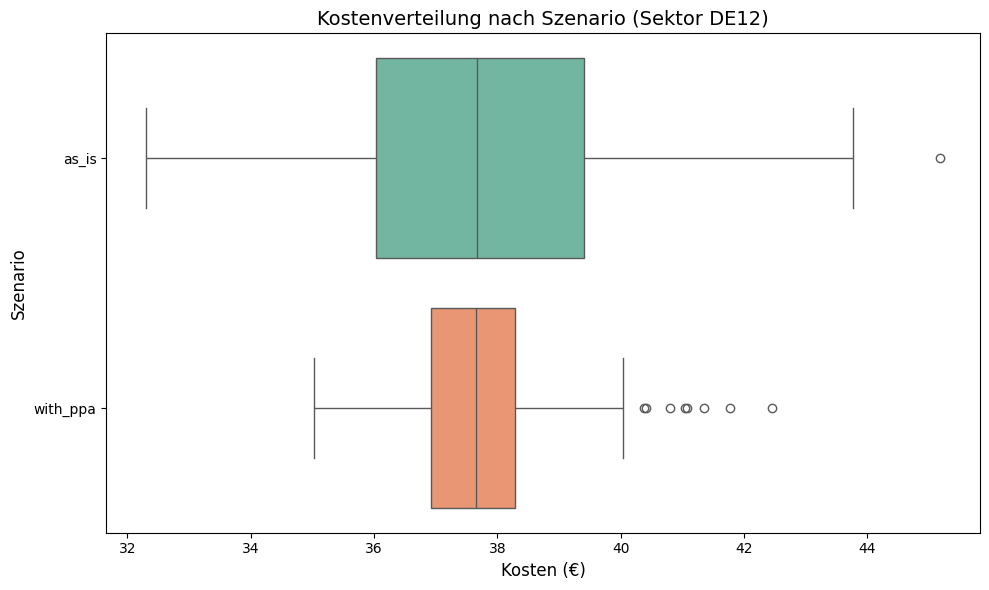

DE134


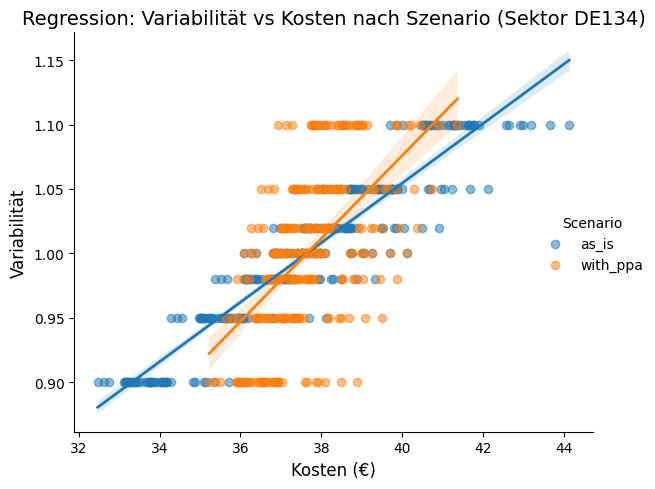

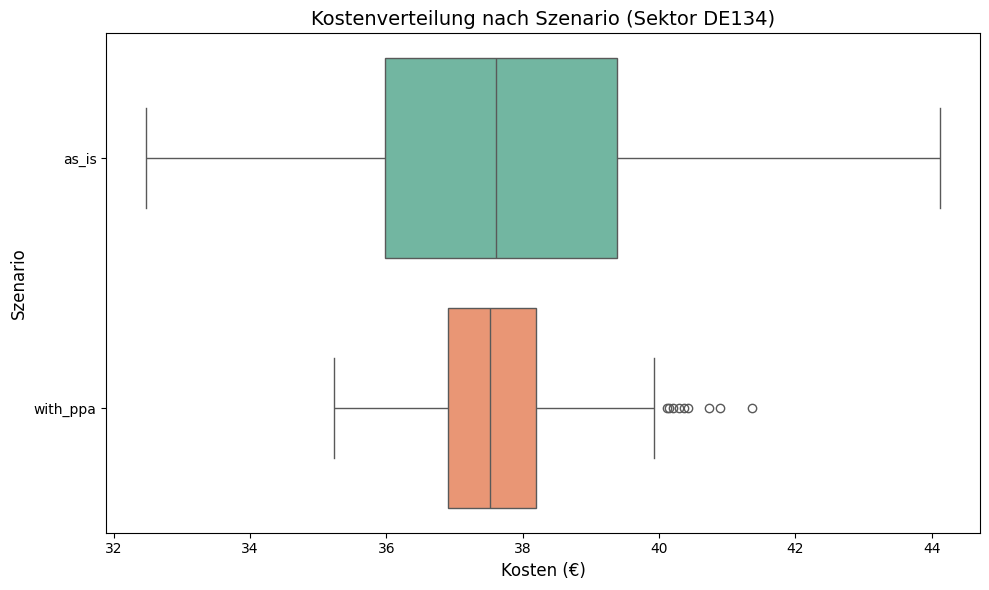

DE136


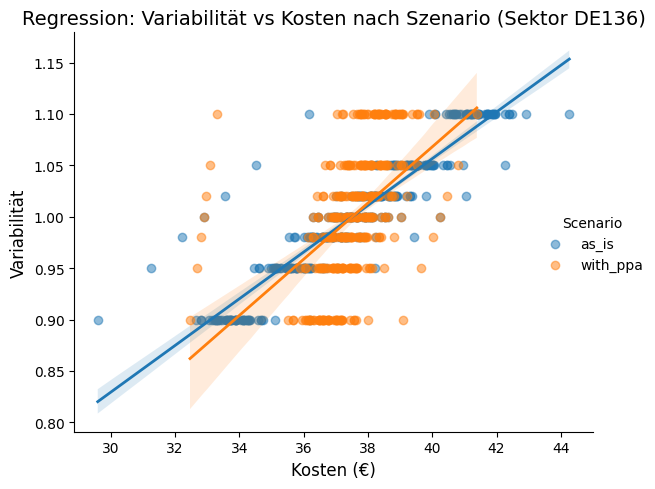

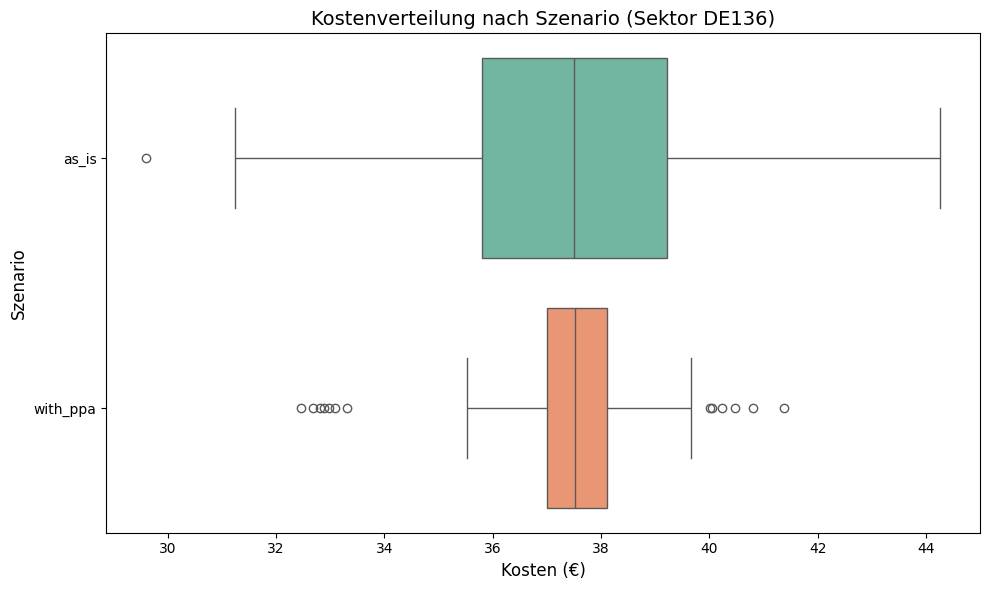

DE14


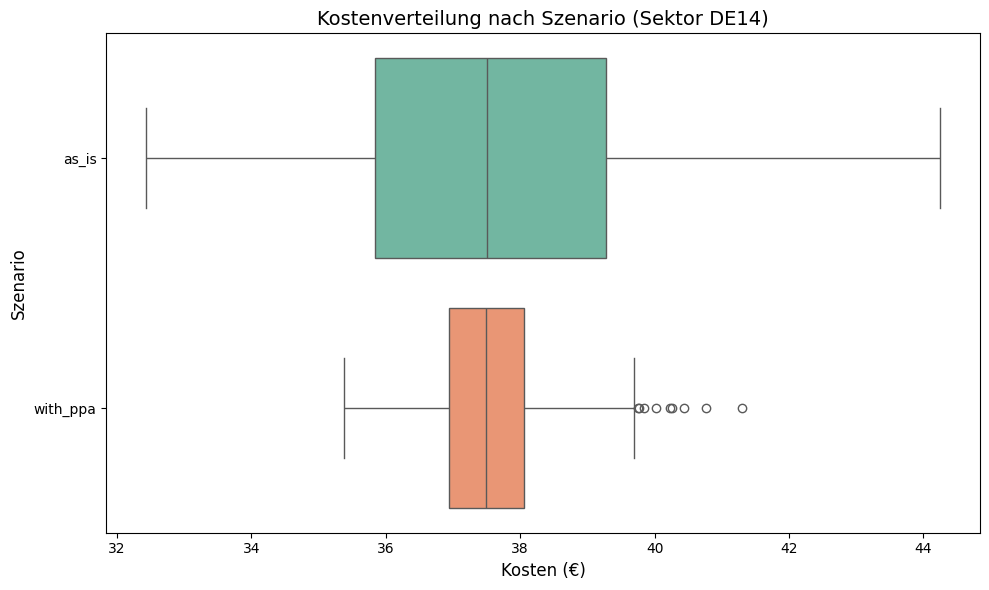

DE147


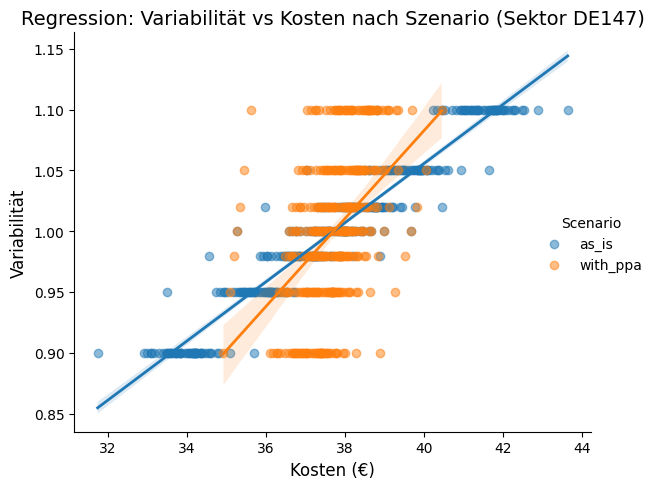

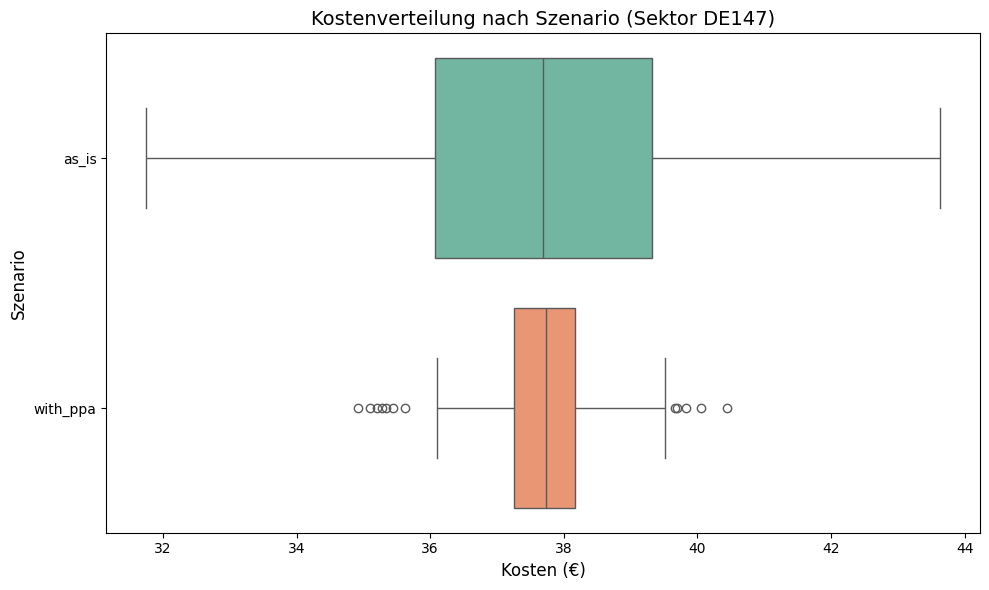

DE211


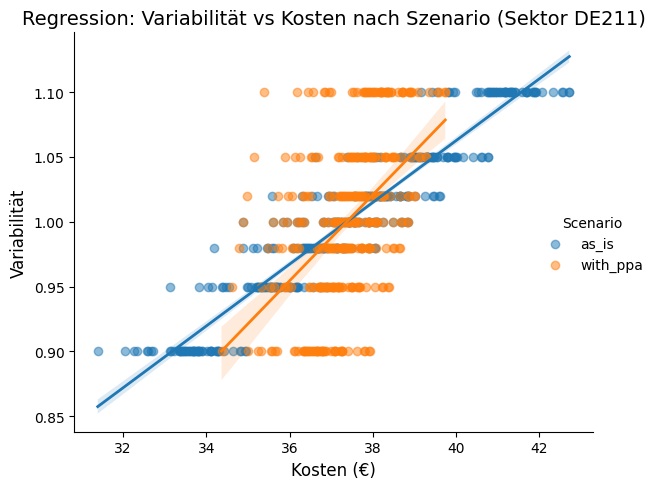

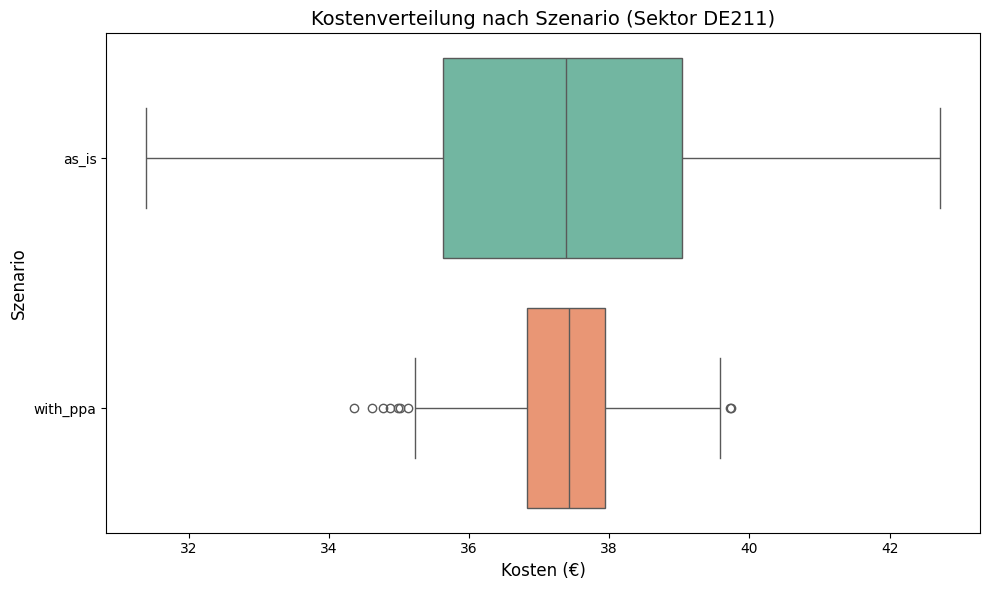

DE212


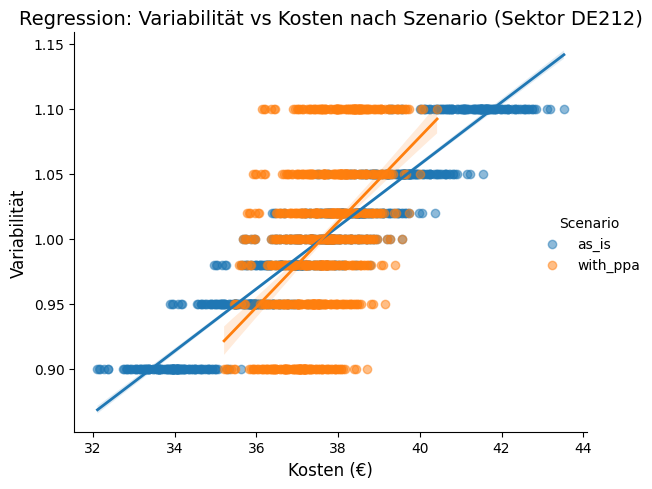

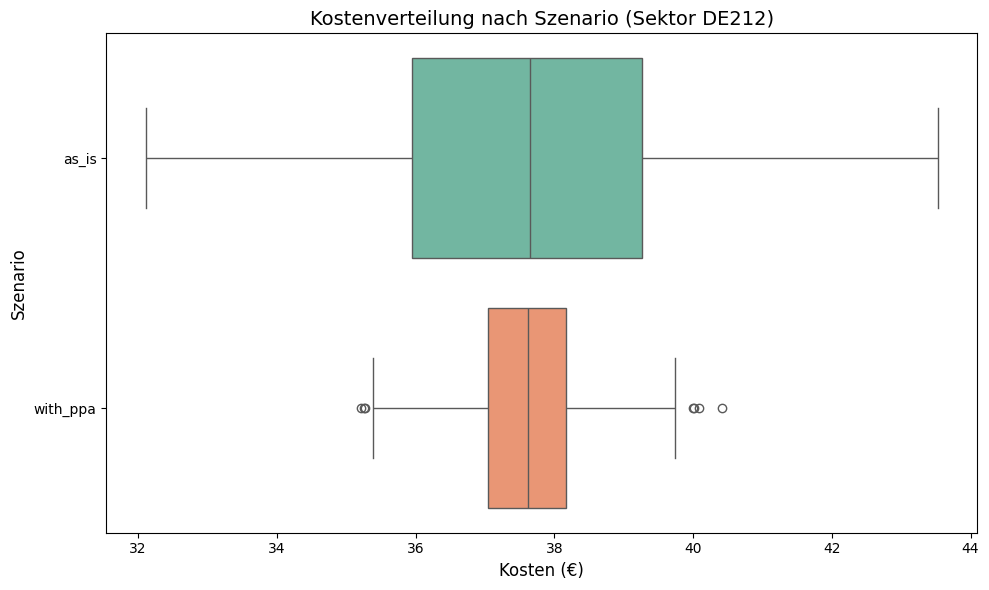

DE222


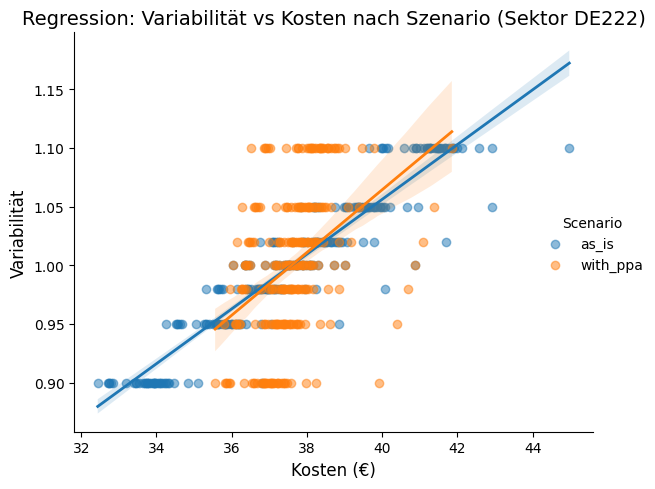

DE232


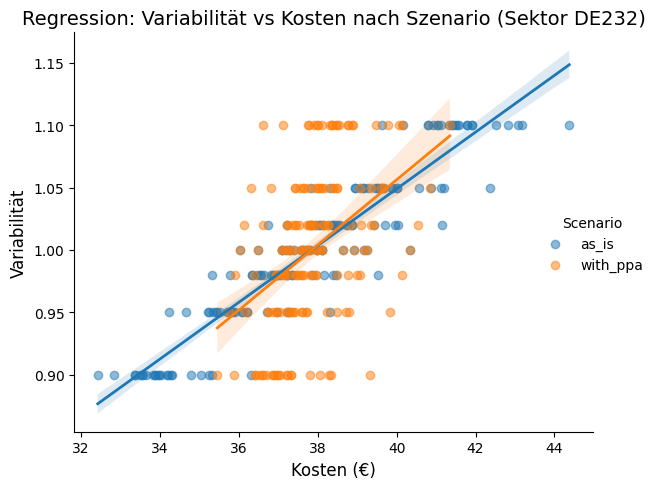

DE244


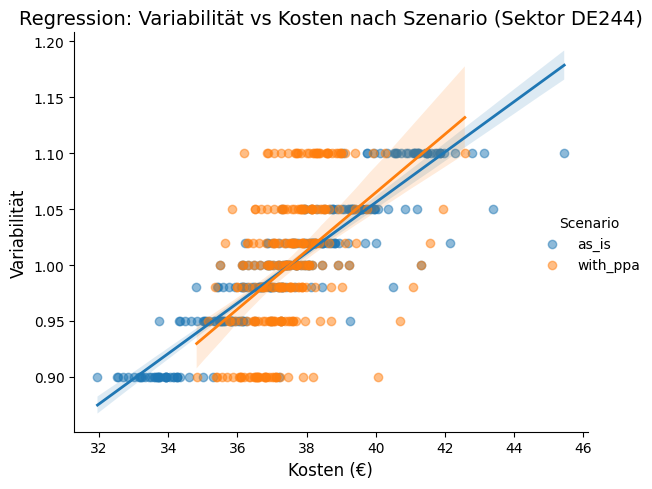

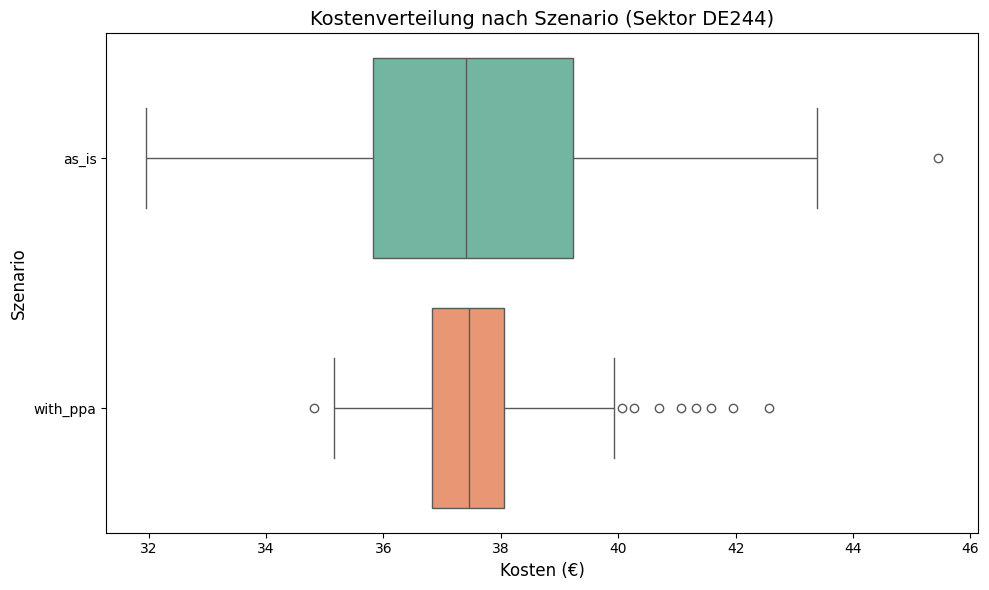

DE24B


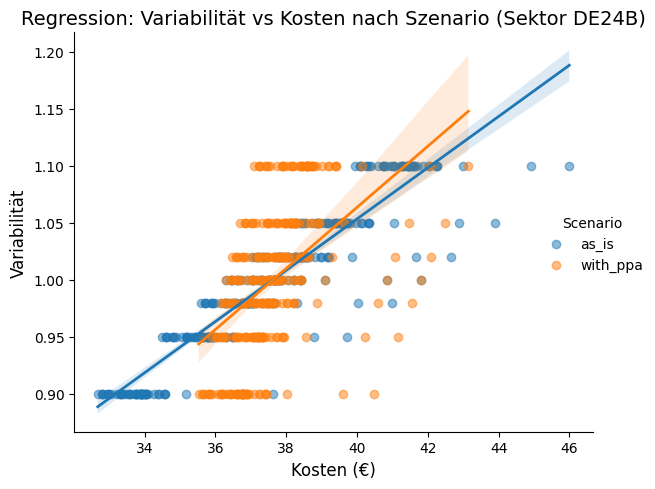

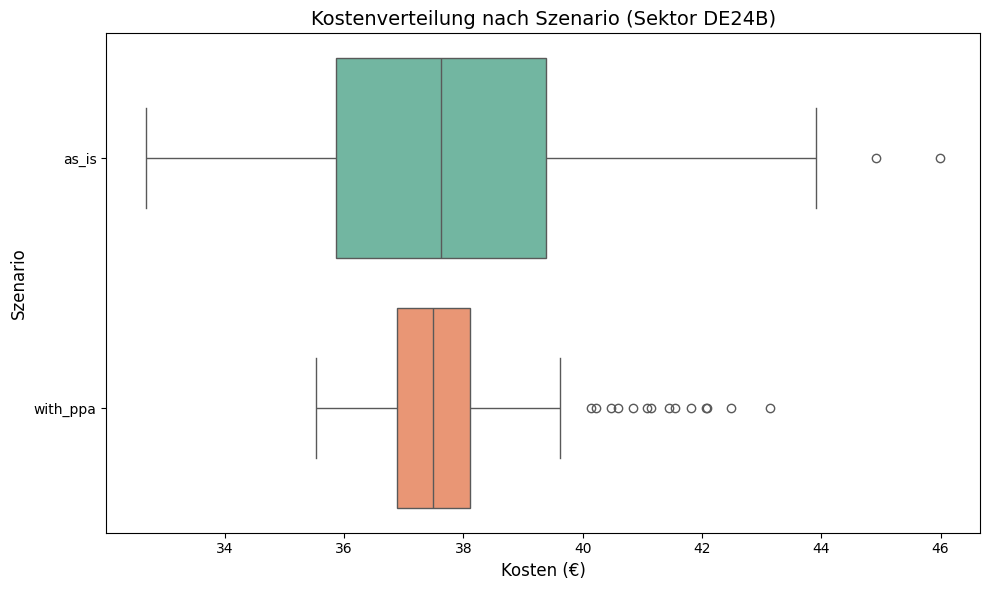

DE252


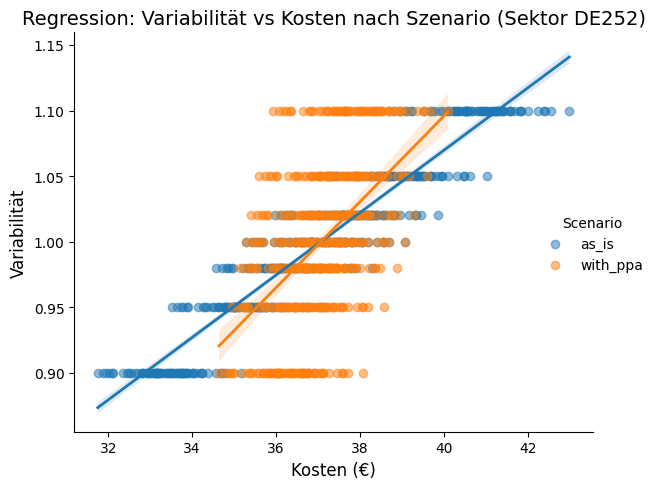

DE263


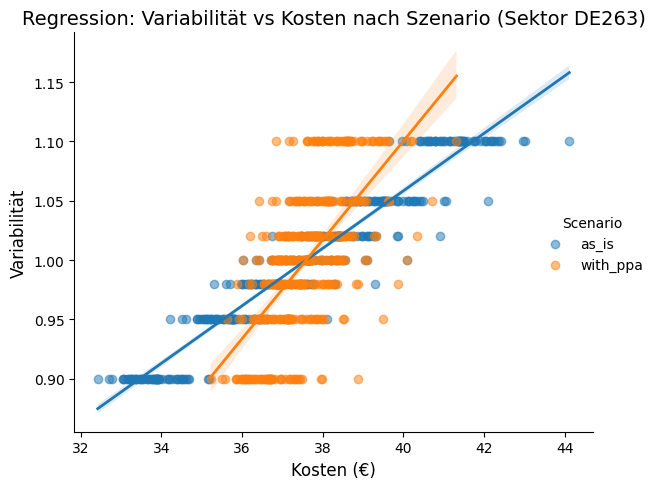

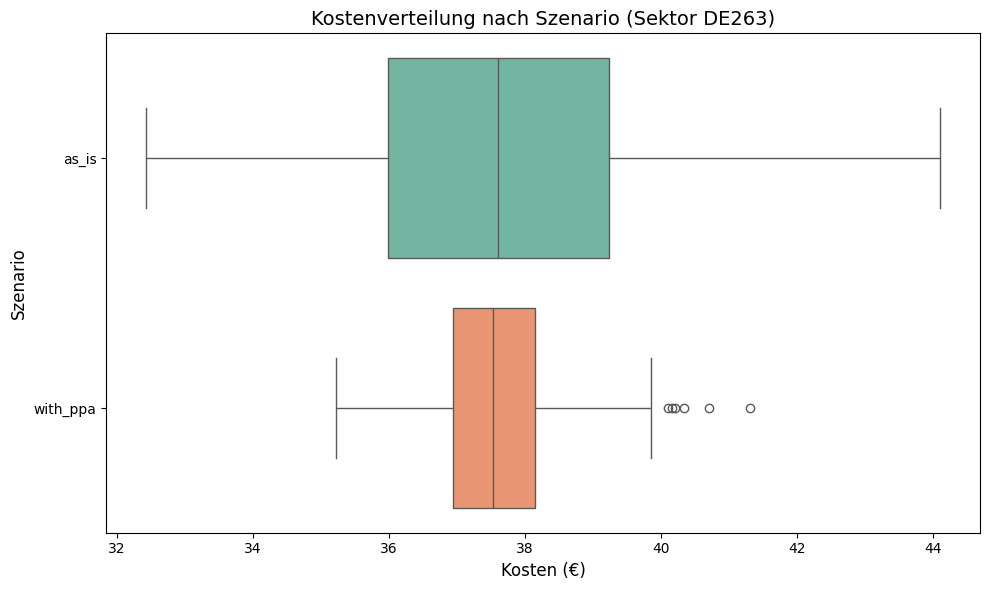

DE271


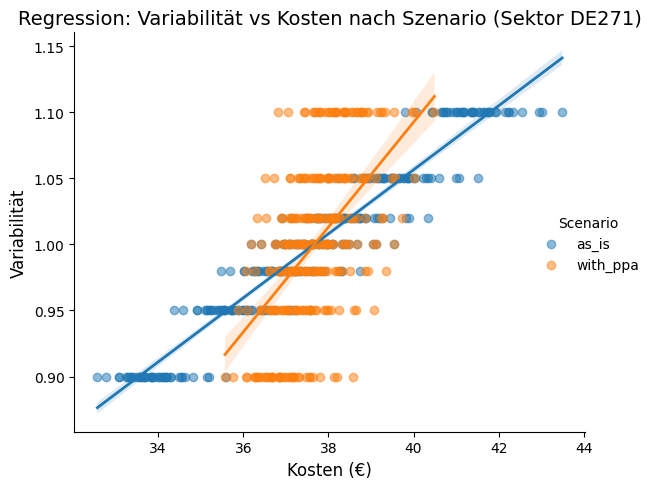

DE300


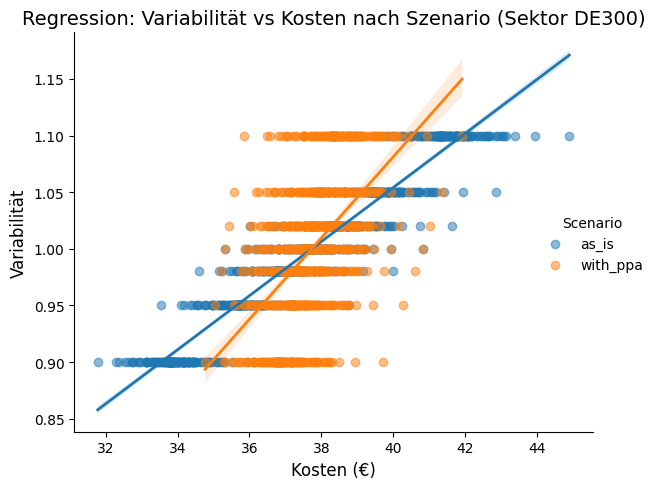

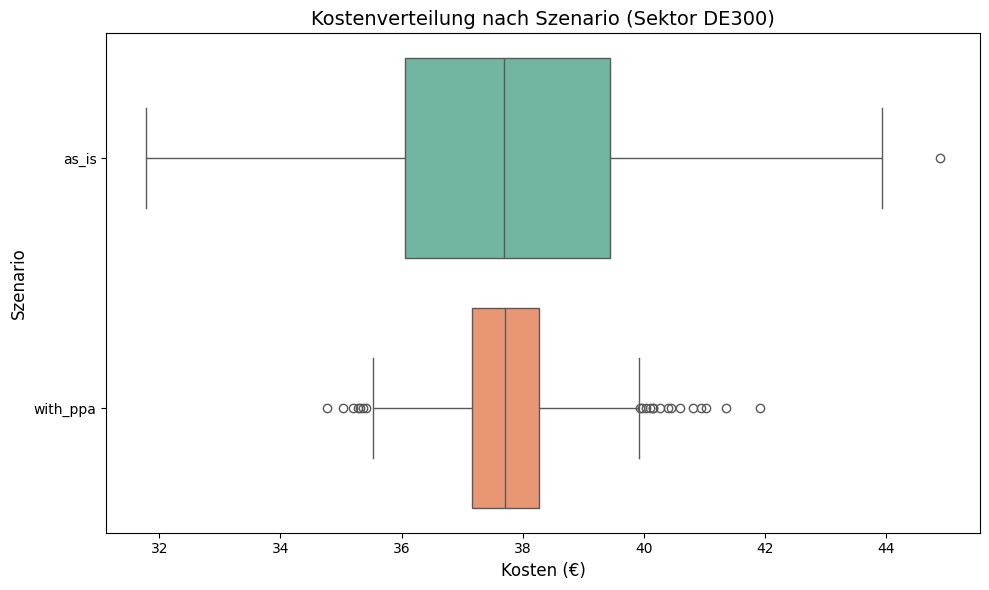

DE501


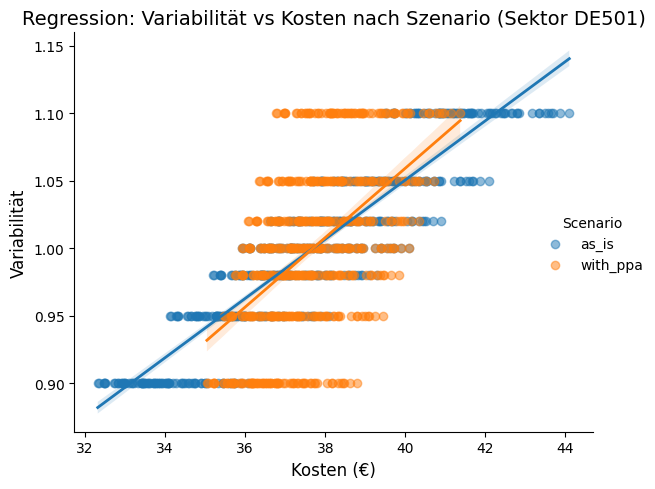

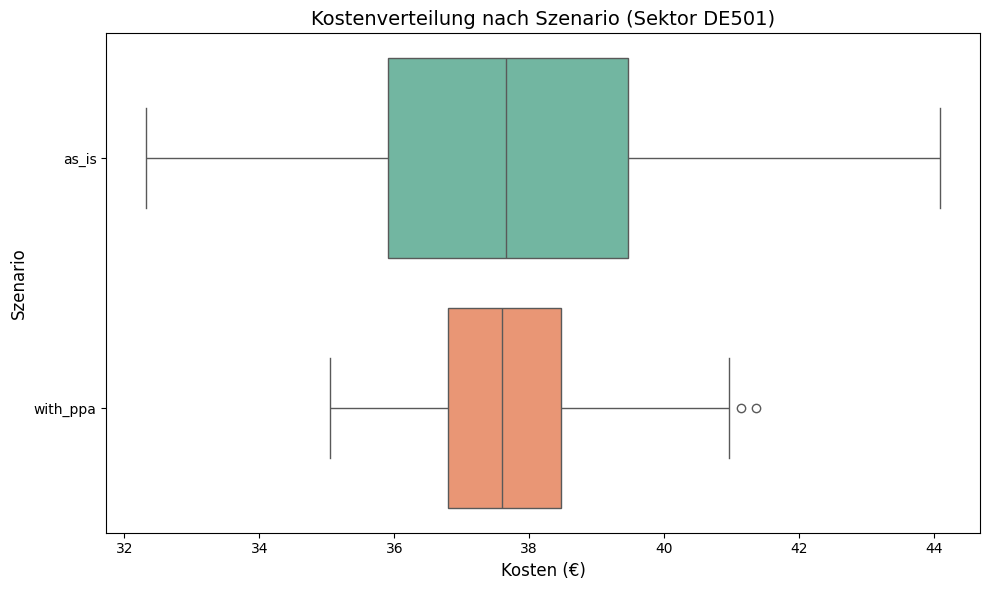

DE6


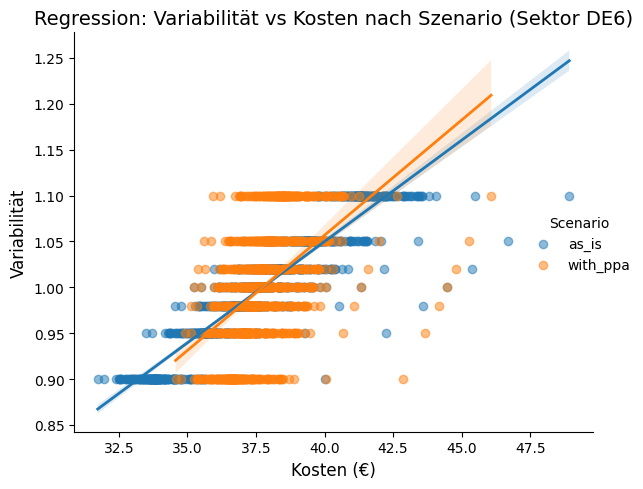

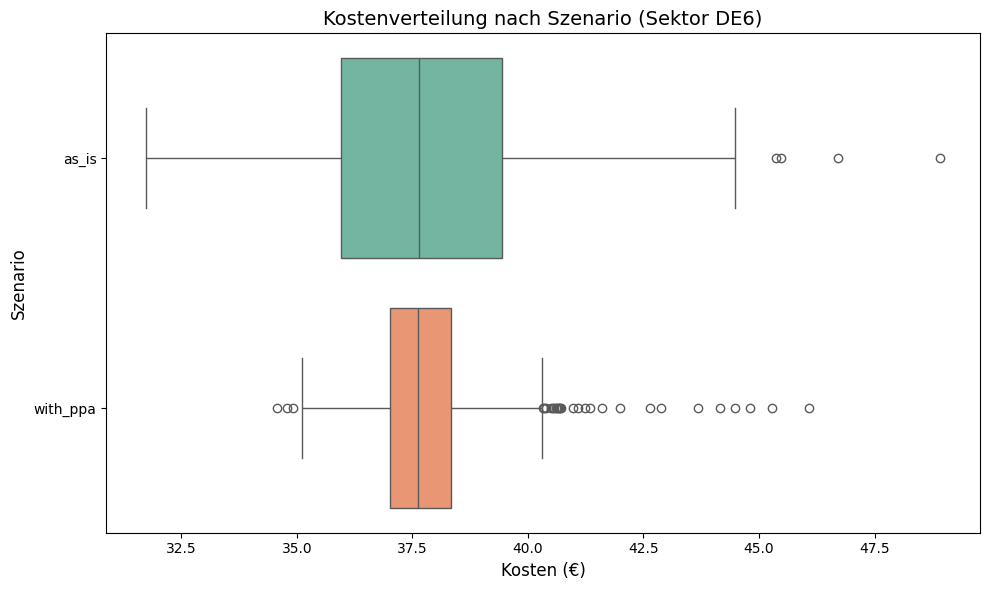

DE711


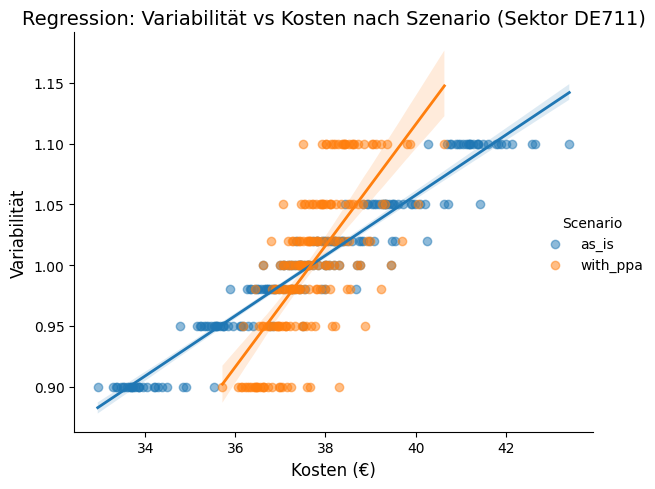

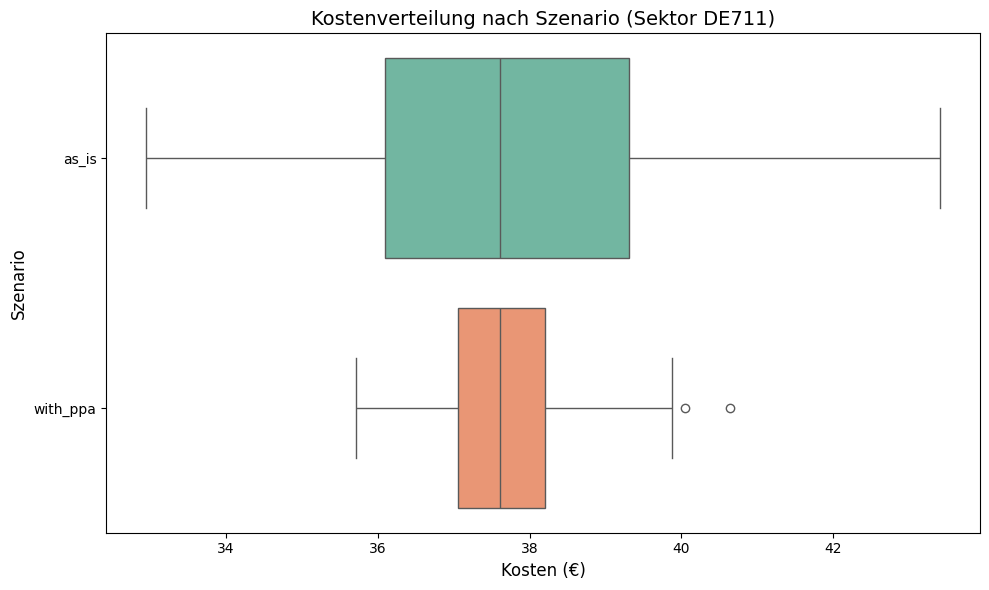

DE712


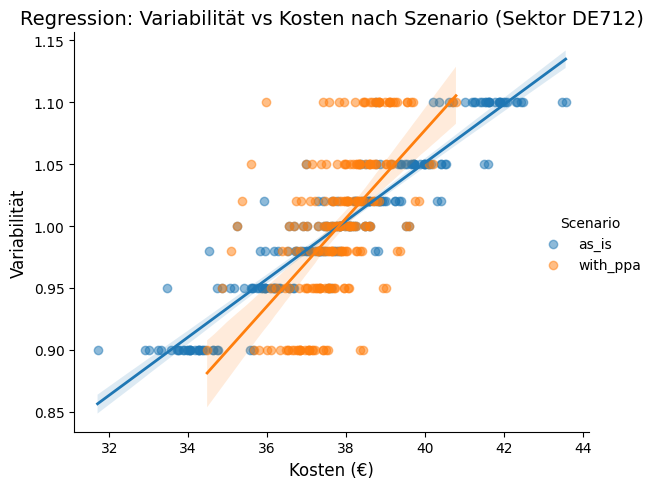

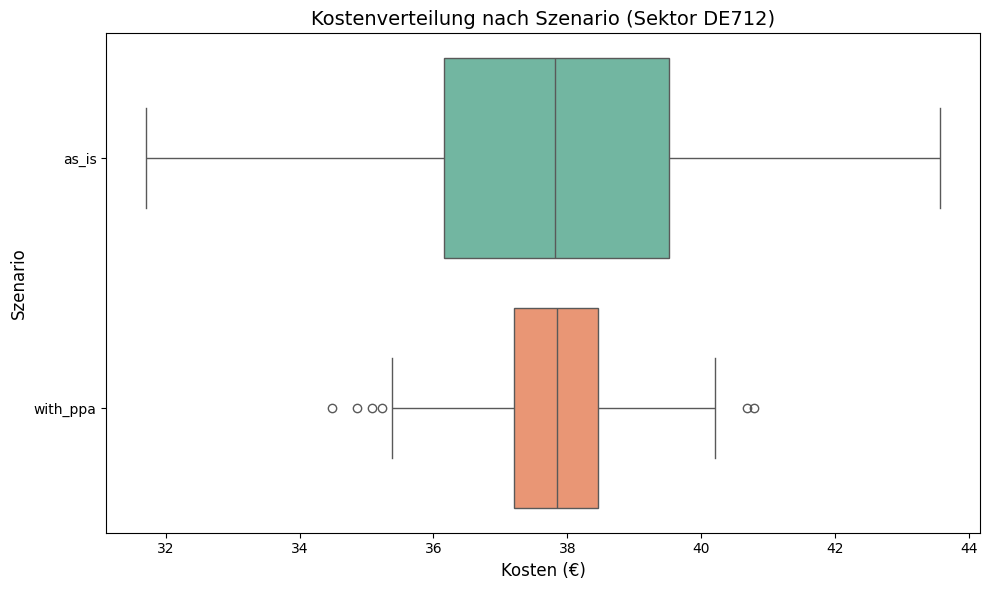

DE713


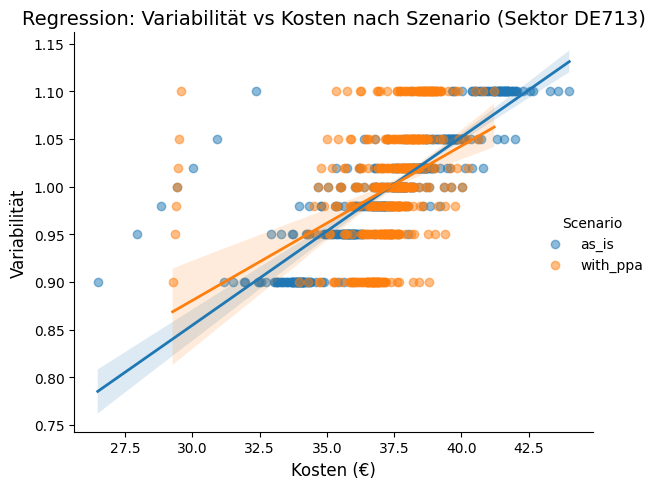

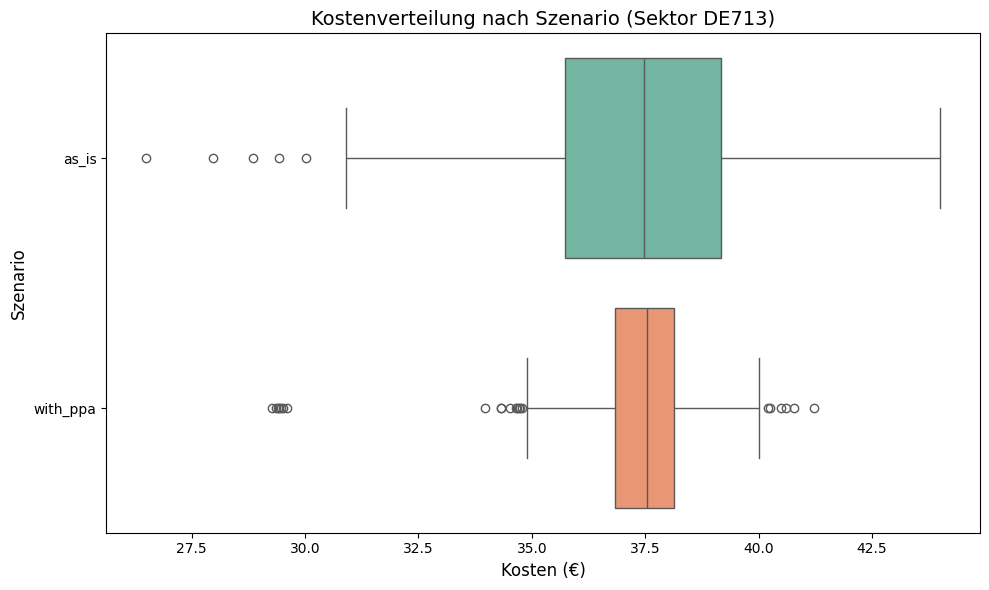

DE71E


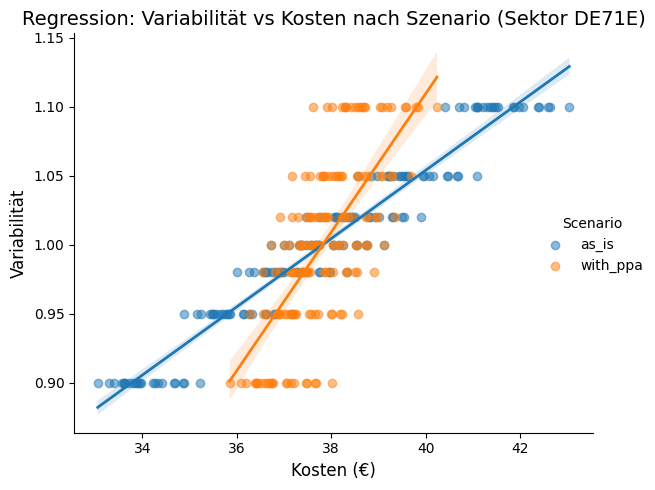

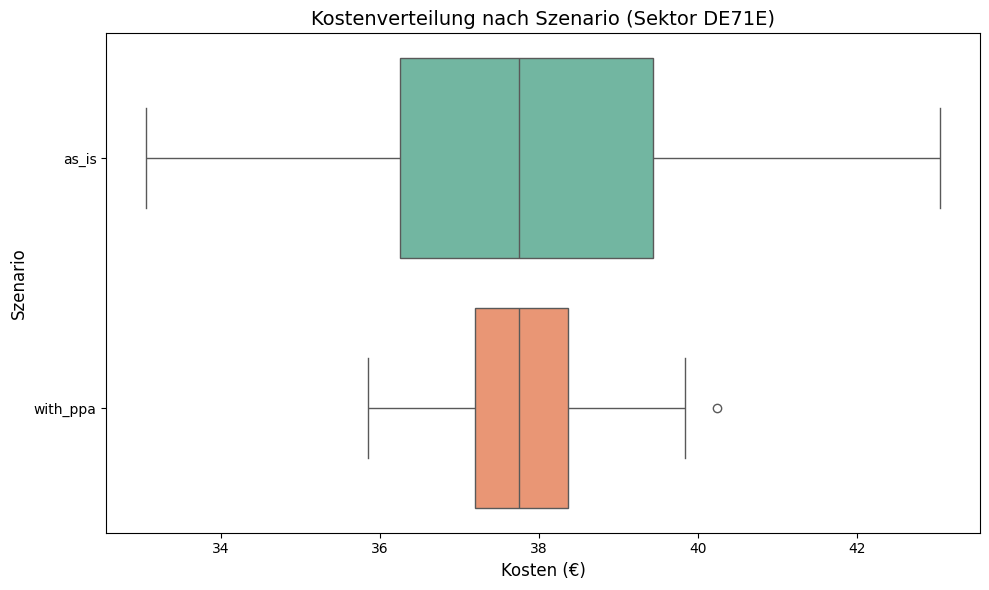

DE731


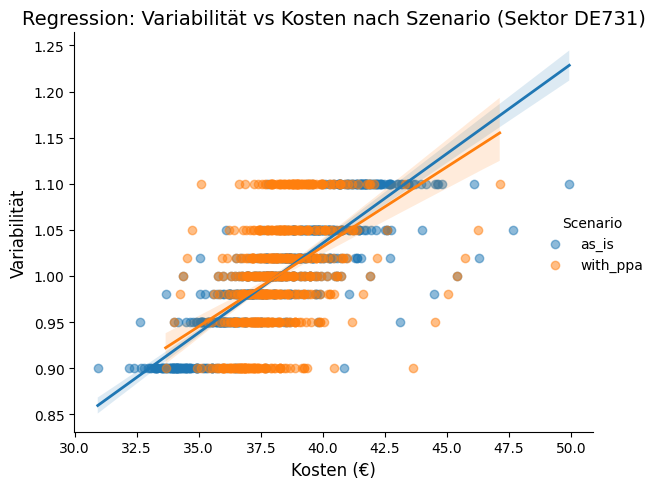

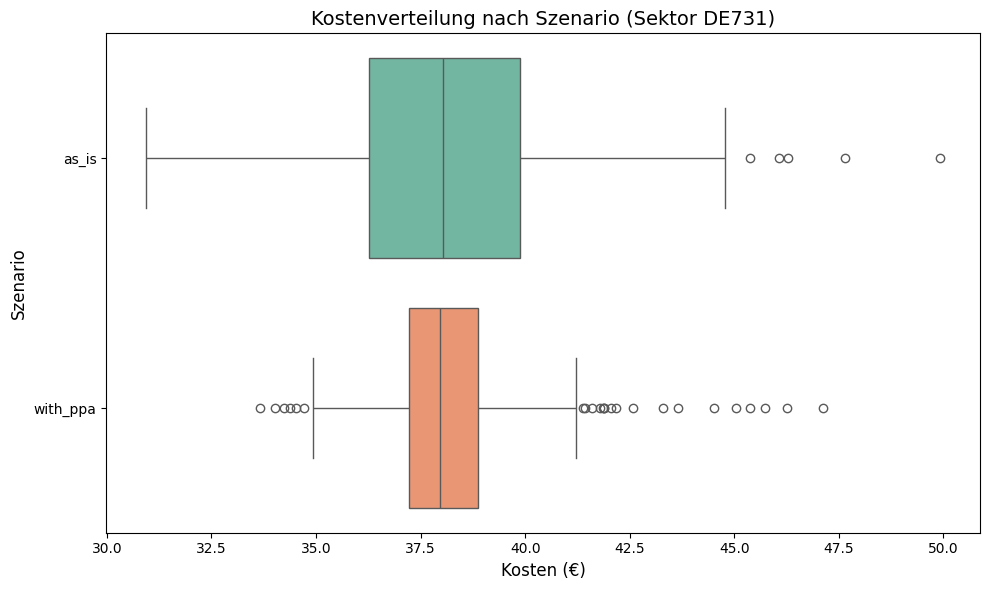

DE803


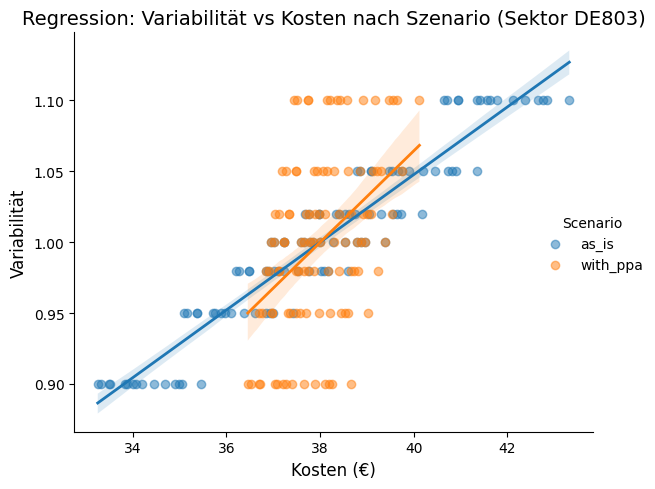

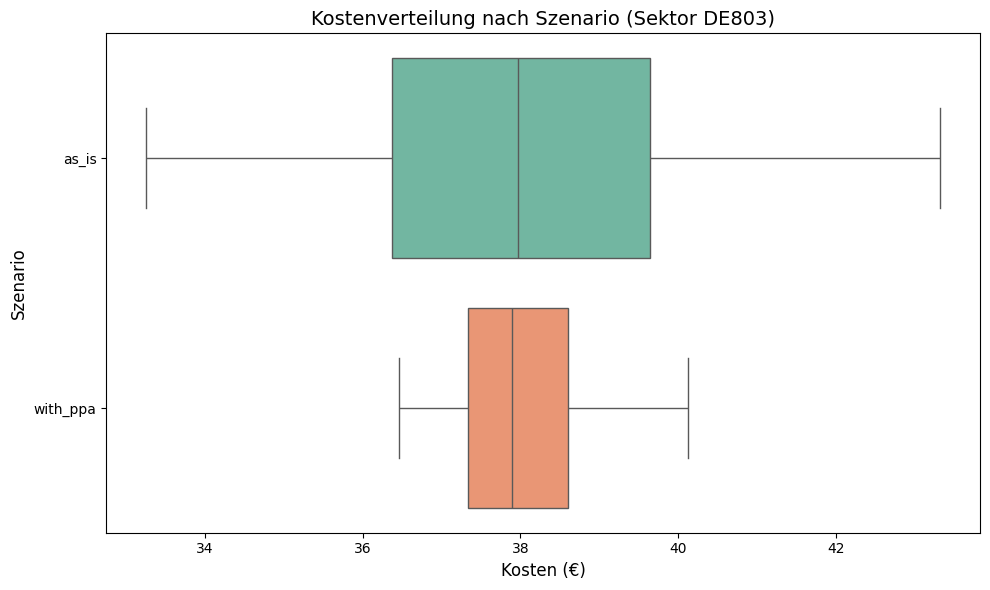

DE804


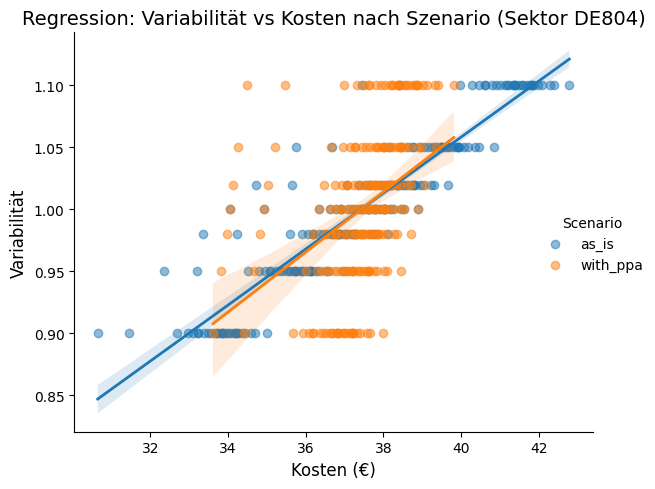

DE91


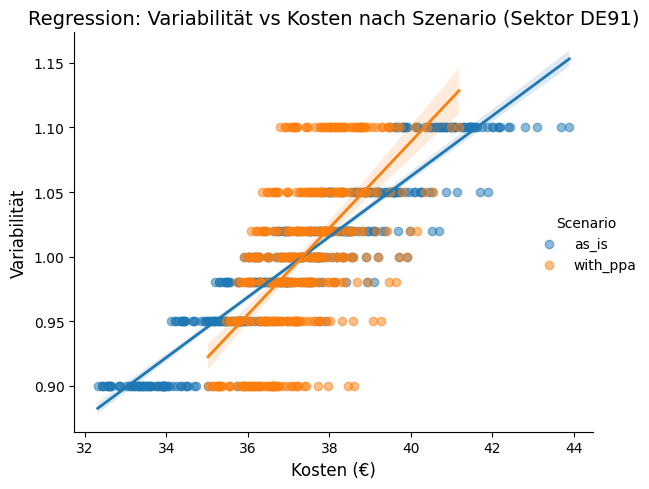

DE929


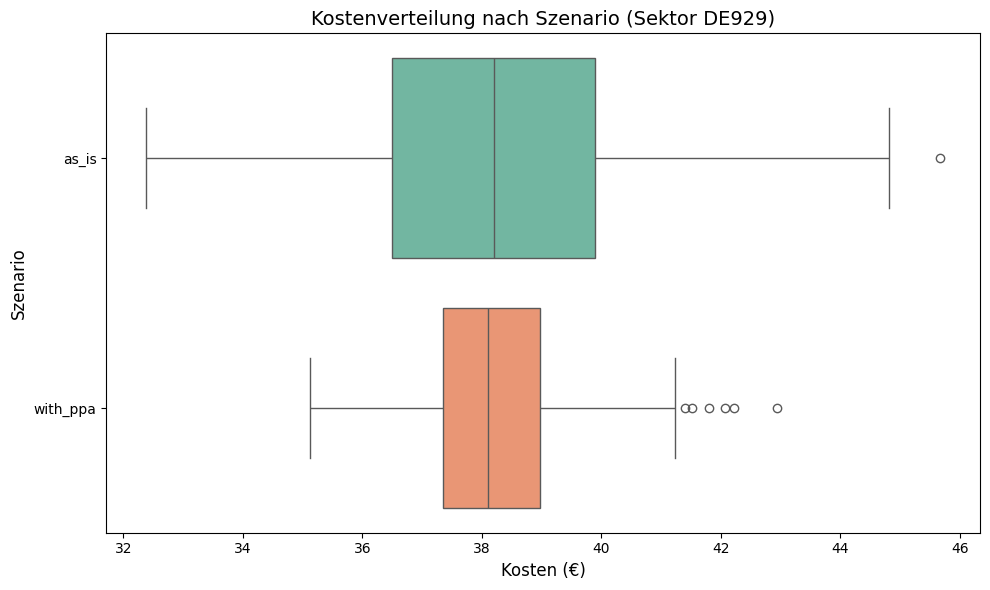

DE944


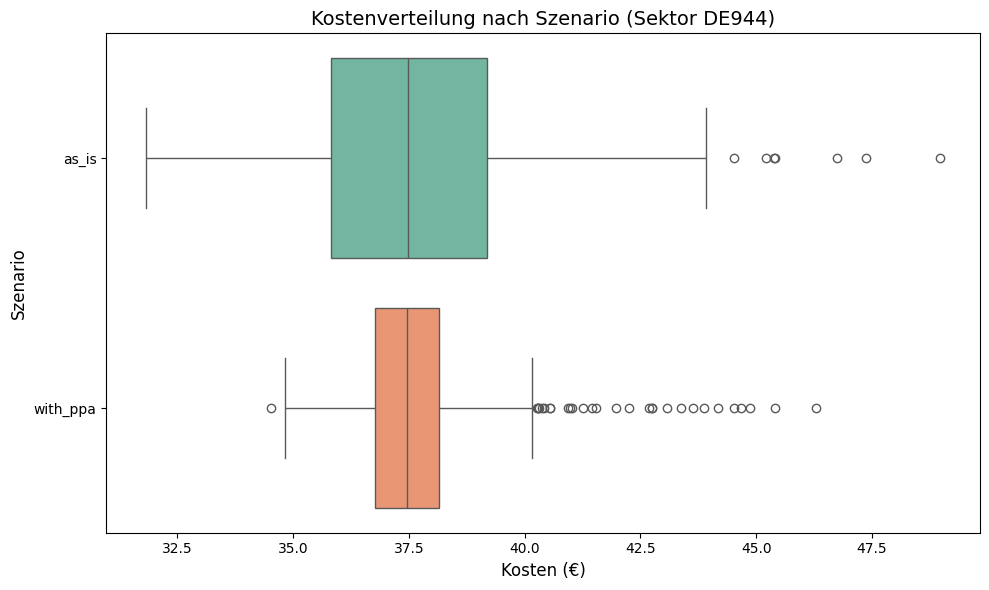

DEA11


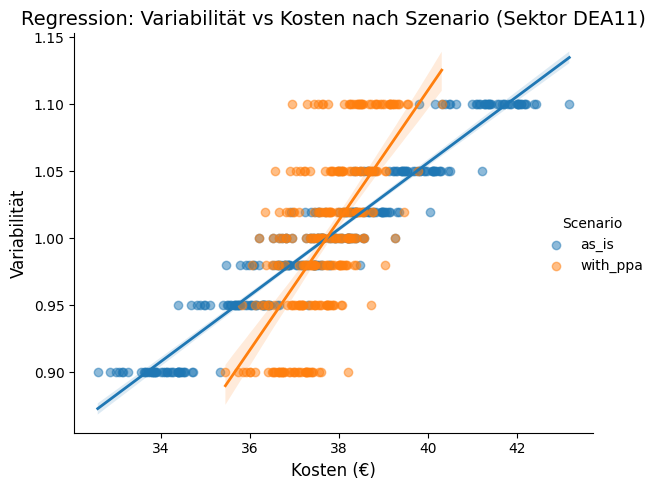

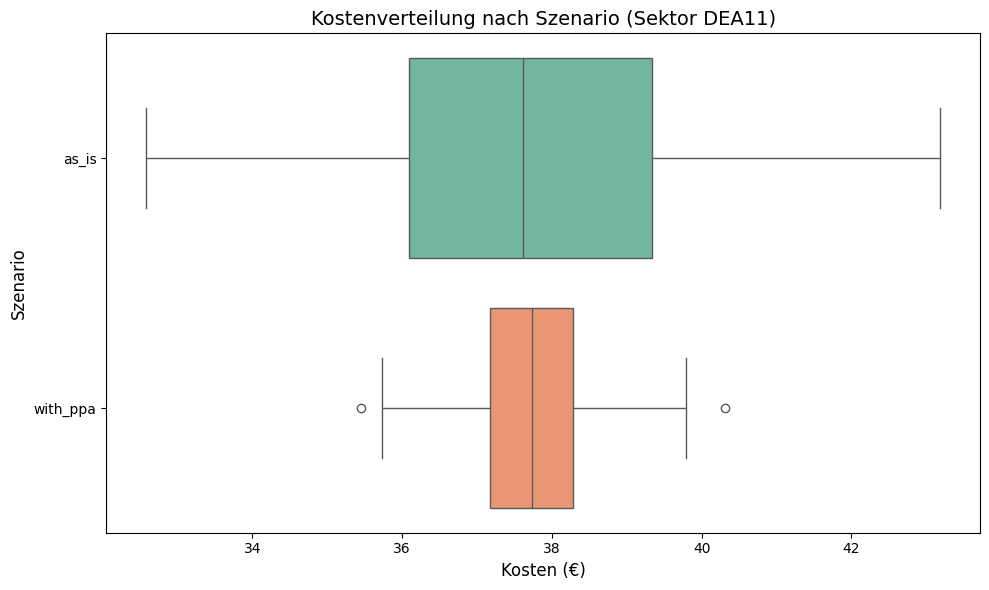

DEA12


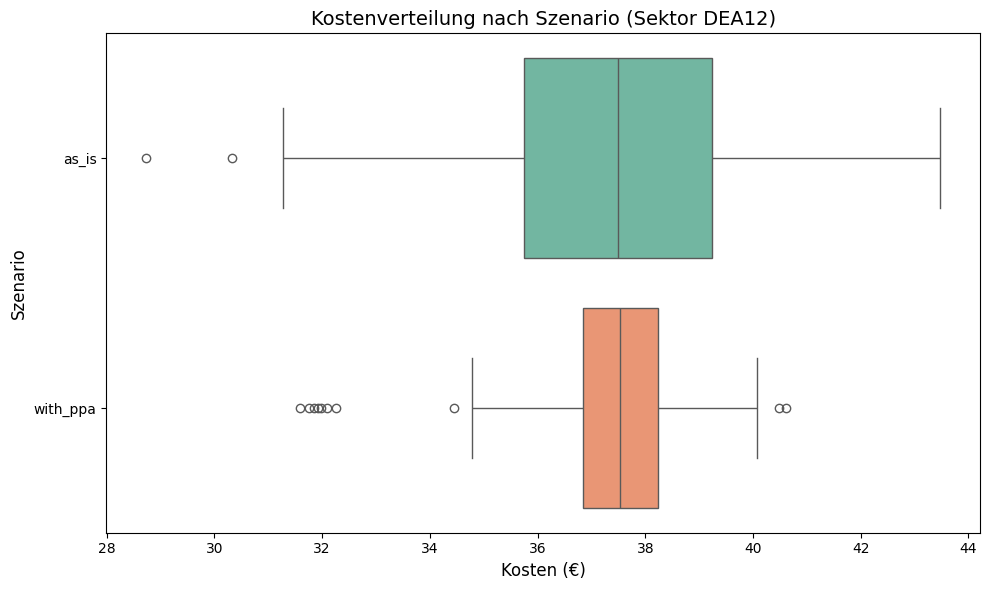

DEA13


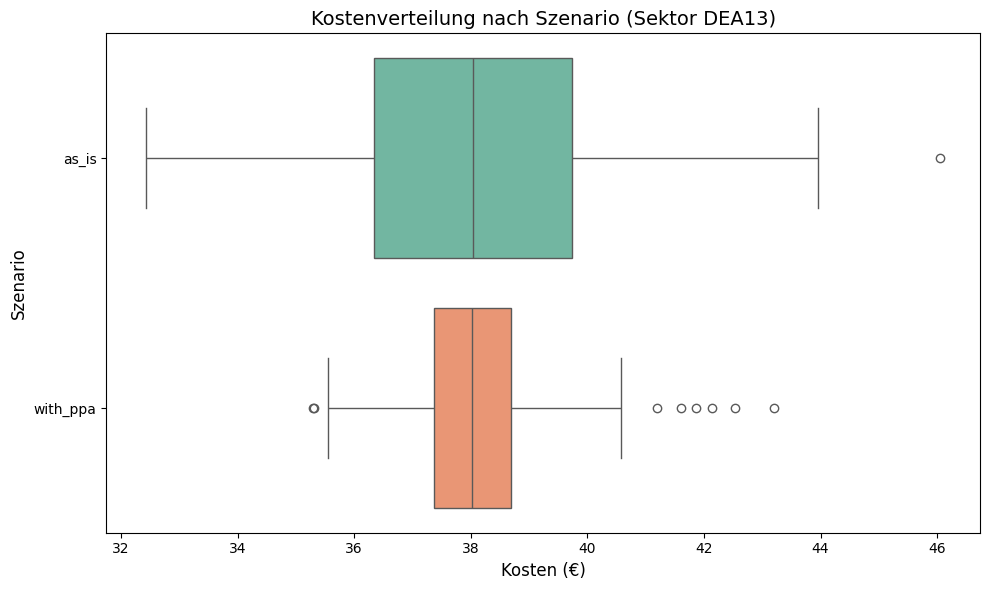

DEA15


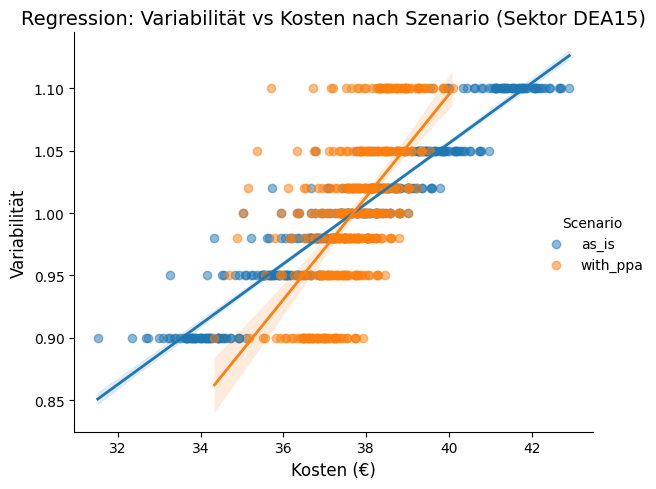

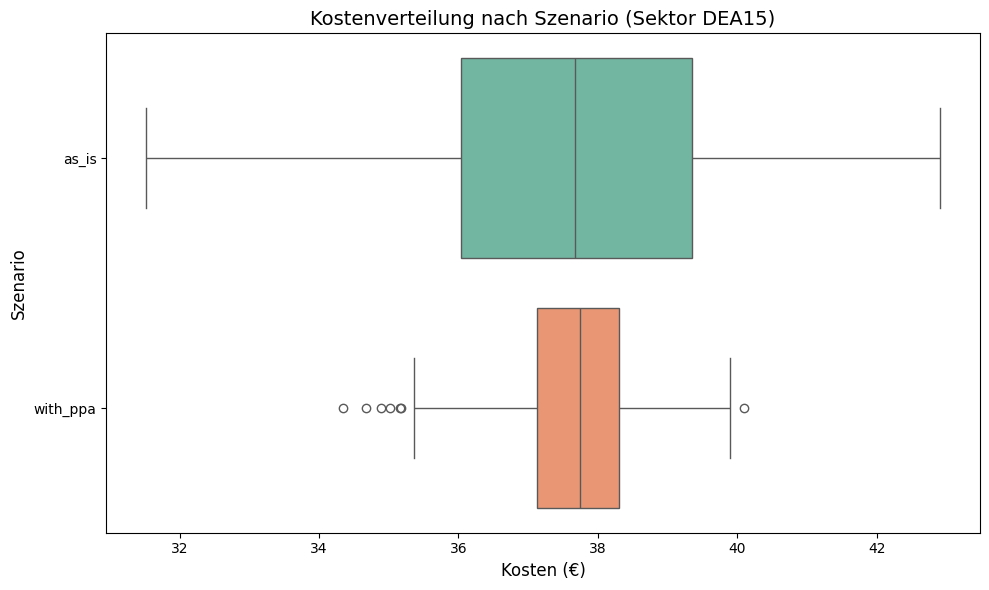

DEA17


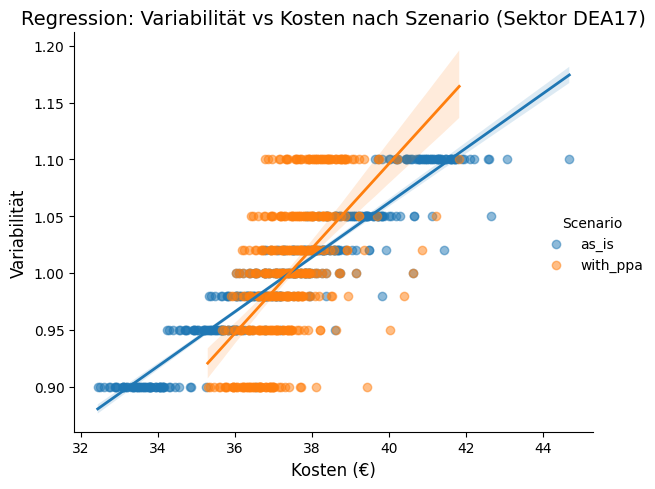

DEA22


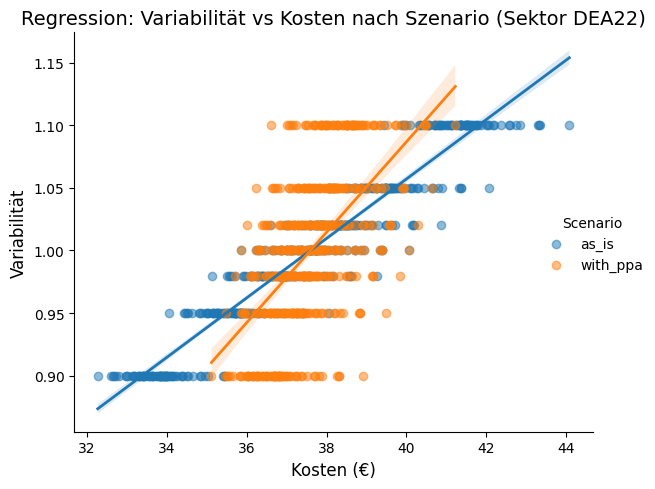

DEA23


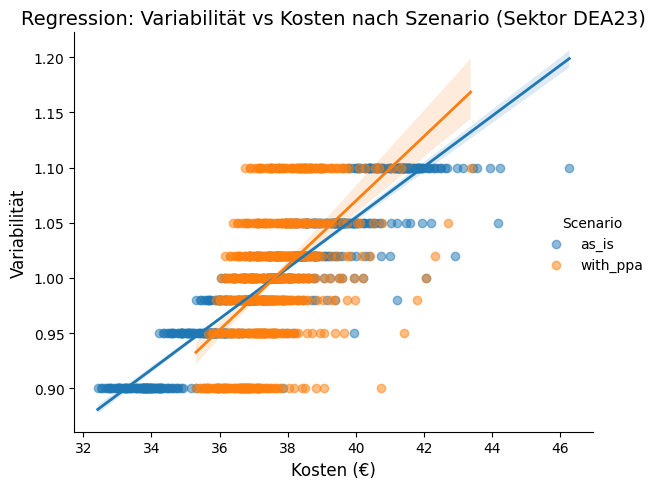

DEA27


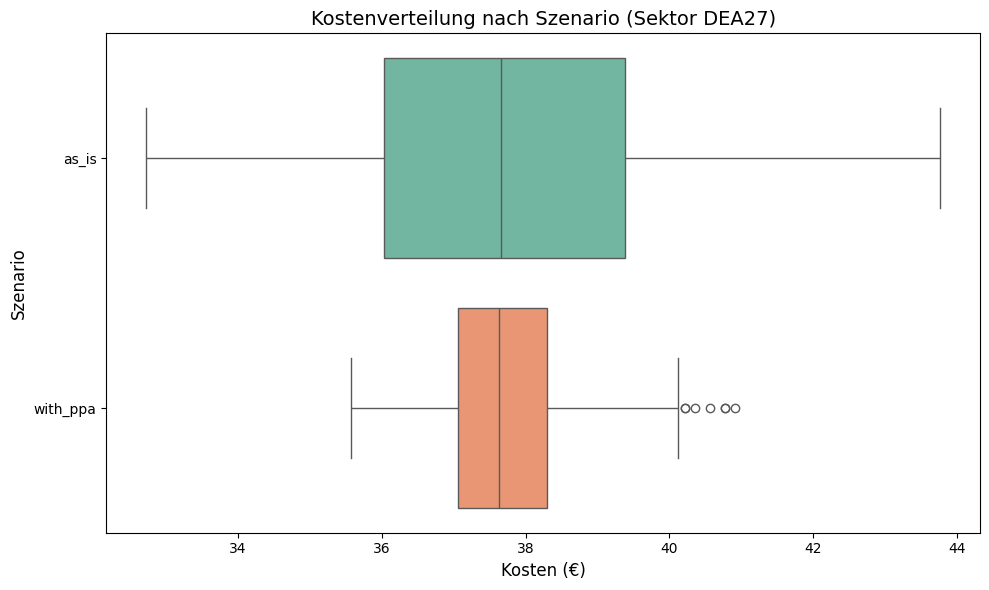

DEA3


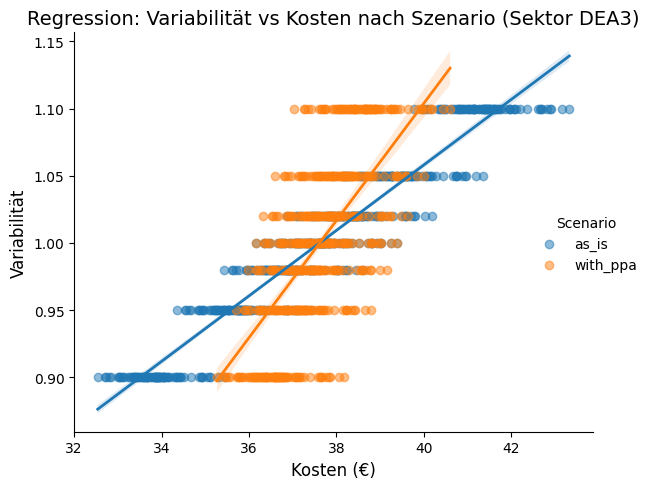

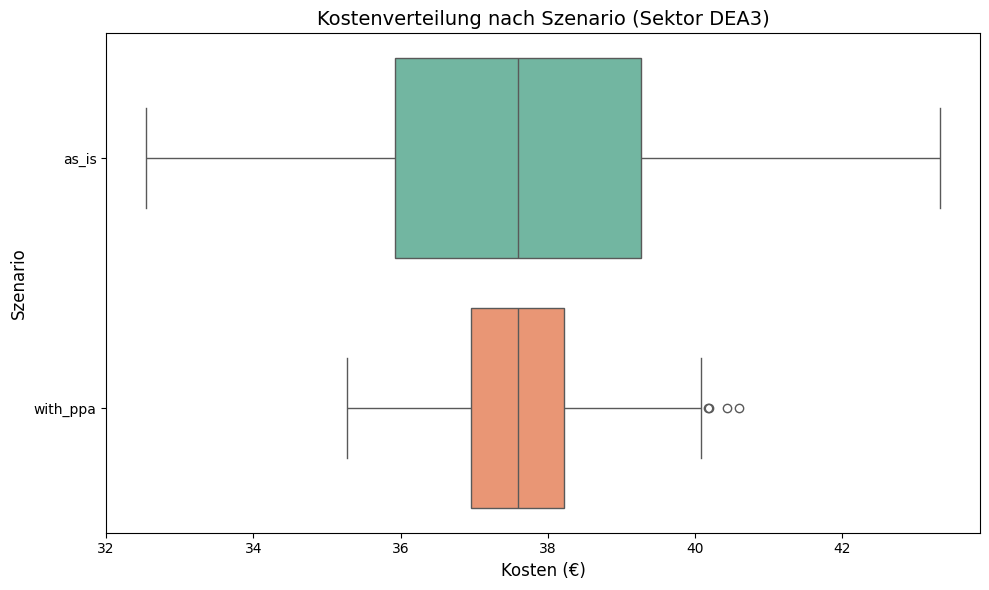

DEA44


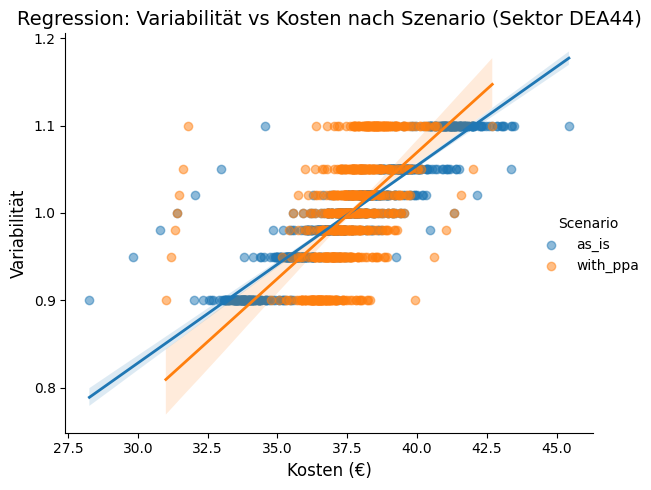

DEA52


DEA53


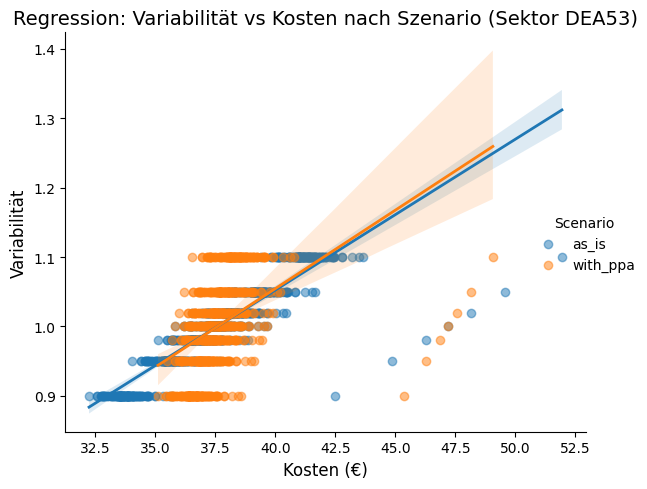

DEA54


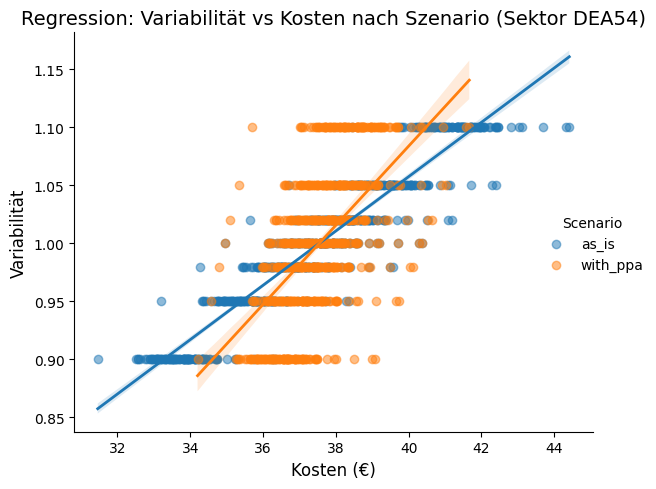

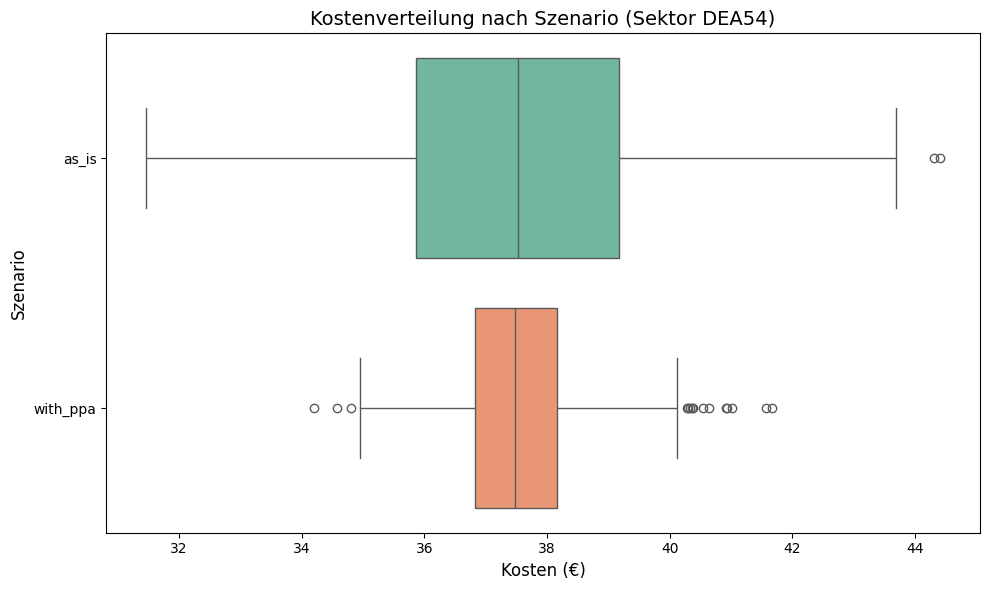

DEB11


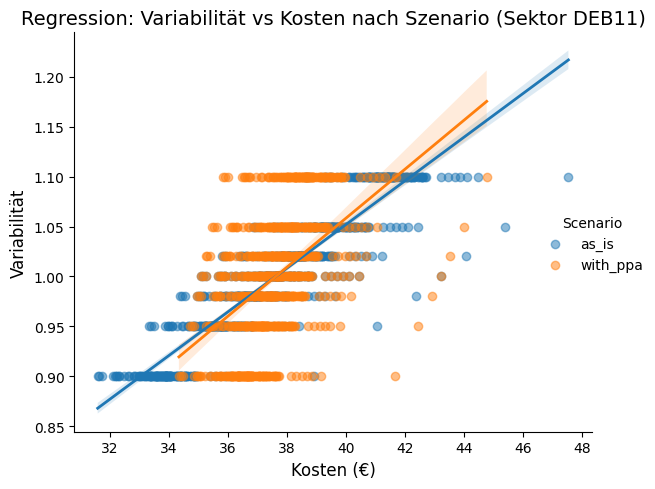

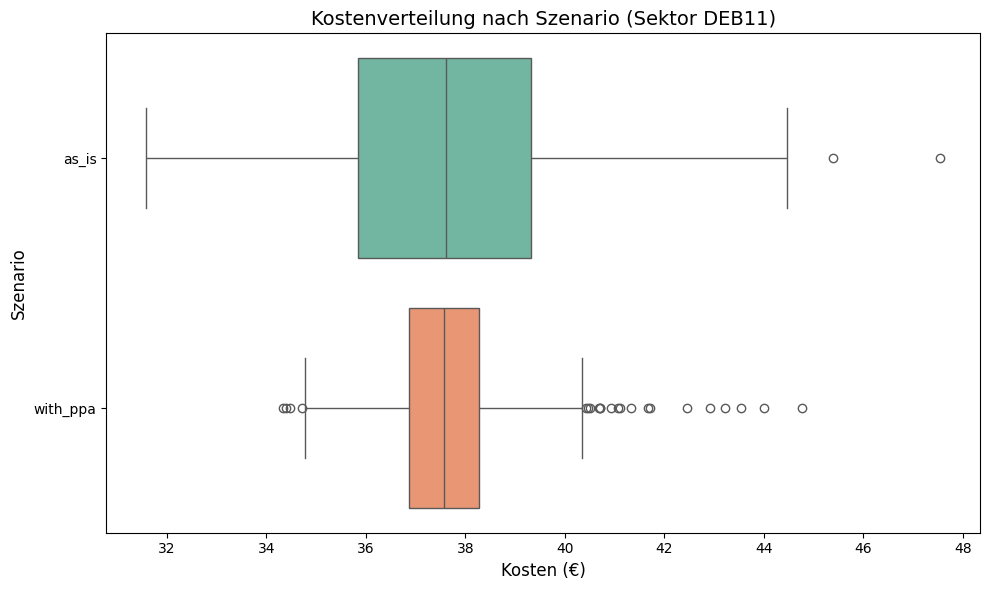

DEB21


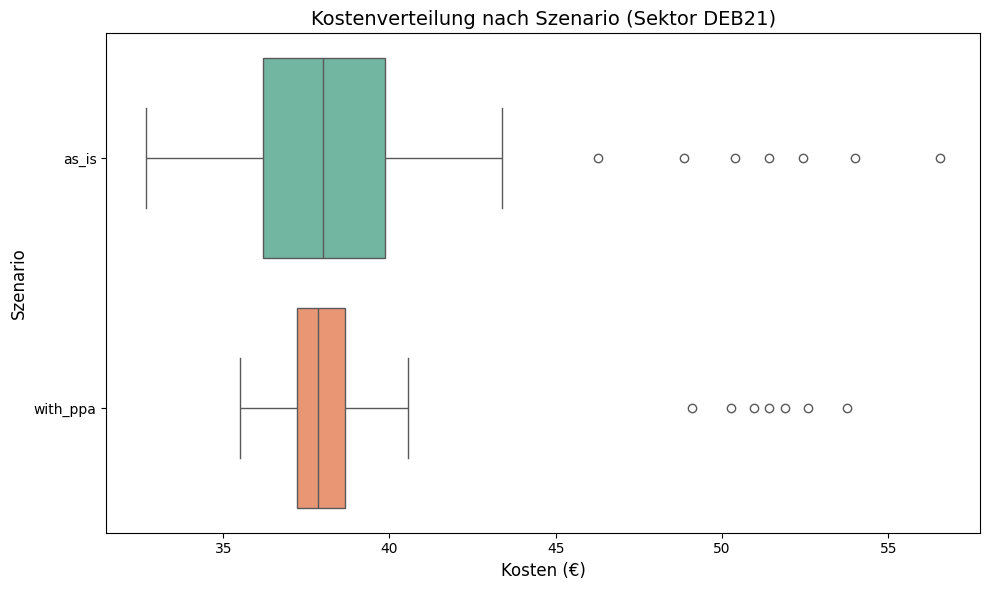

DEB35


DEE03


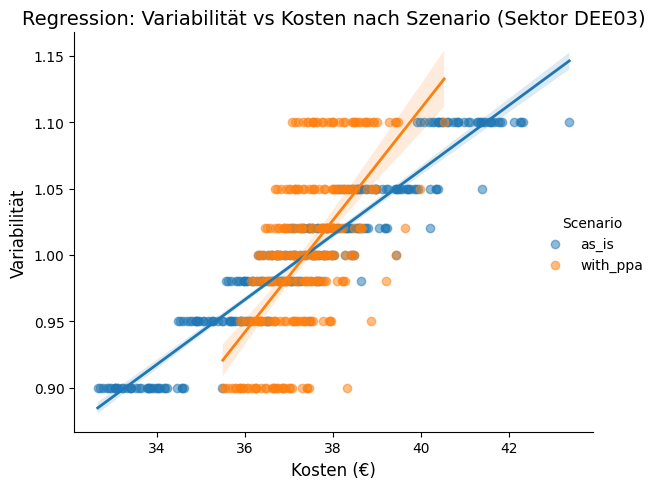

DEF02


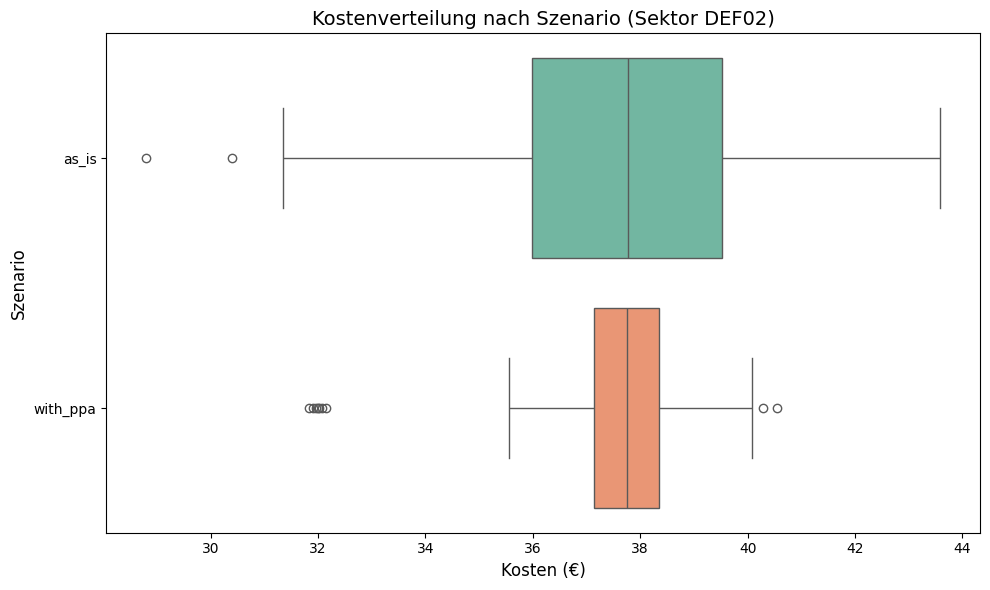

DEF03


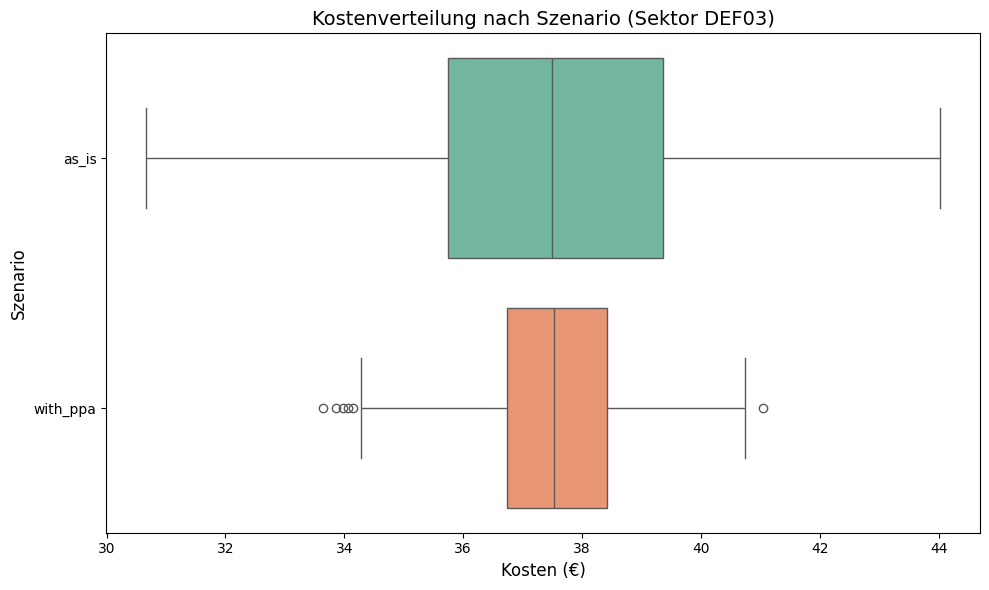

DEG01


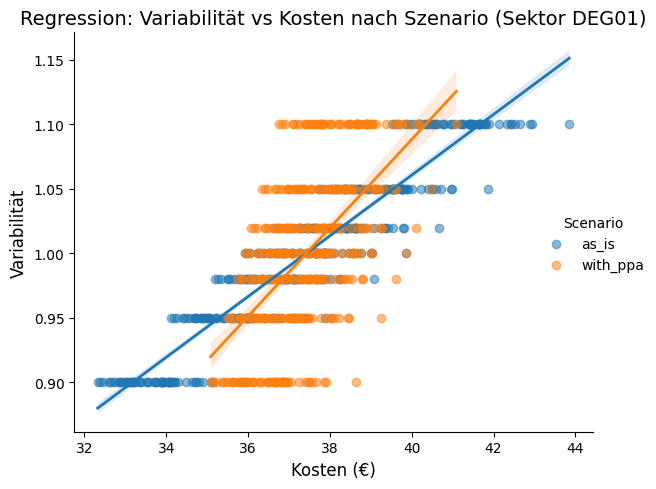

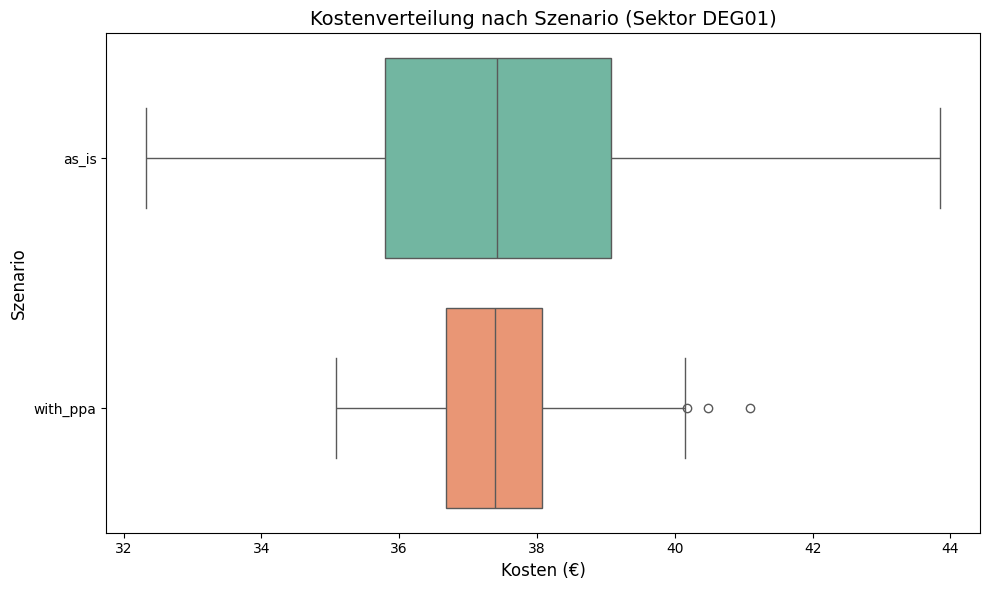

DEG04
(psycopg2.errors.DivisionByZero) division by zero

[SQL: 
    SELECT
        aggregated.profile_id,
        aggregated.nuts_id,
        aggregated."scenario_as_is_0.9",
        aggregated."scenario_as_is_0.95",
        aggregated."scenario_as_is_0.98",
        aggregated."scenario_as_is_1",
        aggregated."scenario_as_is_1.02",
        aggregated."scenario_as_is_1.05",
        aggregated."scenario_as_is_1.1",
        aggregated."scenario_with_ppa_0.9",
        aggregated."scenario_with_ppa_0.95",
        aggregated."scenario_with_ppa_0.98",
        aggregated."scenario_with_ppa_1",
        aggregated."scenario_with_ppa_1.02",
        aggregated."scenario_with_ppa_1.05",
        aggregated."scenario_with_ppa_1.1",
        plz_data.latitude,
        plz_data.longitude
    FROM (
        SELECT
            profile_id,
            nuts_id,
            plz,
            SUM("scenario_as_is_0.9(€)") / SUM("load(mwh)") AS "scenario_as_is_0.9",
            SUM("scenario_as_is_0.95(€)"

In [149]:
# Szenarien und Variabilitäten definieren
scenarios = ['as_is', 'with_ppa']
variabilities = [0.9, 0.95, 0.98, 1, 1.02, 1.05, 1.1]

for nuts_id in nuts_ids:
    print(nuts_id)
    # SQL-Abfrage dynamisch anpassen
    query = f"""
    SELECT
        aggregated.profile_id,
        aggregated.nuts_id,
        aggregated."scenario_as_is_0.9",
        aggregated."scenario_as_is_0.95",
        aggregated."scenario_as_is_0.98",
        aggregated."scenario_as_is_1",
        aggregated."scenario_as_is_1.02",
        aggregated."scenario_as_is_1.05",
        aggregated."scenario_as_is_1.1",
        aggregated."scenario_with_ppa_0.9",
        aggregated."scenario_with_ppa_0.95",
        aggregated."scenario_with_ppa_0.98",
        aggregated."scenario_with_ppa_1",
        aggregated."scenario_with_ppa_1.02",
        aggregated."scenario_with_ppa_1.05",
        aggregated."scenario_with_ppa_1.1",
        plz_data.latitude,
        plz_data.longitude
    FROM (
        SELECT
            profile_id,
            nuts_id,
            plz,
            SUM("scenario_as_is_0.9(€)") / SUM("load(mwh)") AS "scenario_as_is_0.9",
            SUM("scenario_as_is_0.95(€)") / SUM("load(mwh)") AS "scenario_as_is_0.95",
            SUM("scenario_as_is_0.98(€)") / SUM("load(mwh)") AS "scenario_as_is_0.98",
            SUM("scenario_as_is_1(€)") / SUM("load(mwh)") AS "scenario_as_is_1",
            SUM("scenario_as_is_1.02(€)") / SUM("load(mwh)") AS "scenario_as_is_1.02",
            SUM("scenario_as_is_1.05(€)") / SUM("load(mwh)") AS "scenario_as_is_1.05",
            SUM("scenario_as_is_1.1(€)") / SUM("load(mwh)") AS "scenario_as_is_1.1",
            SUM("scenario_with_ppa_0.9(€)") / SUM("load(mwh)") AS "scenario_with_ppa_0.9",
            SUM("scenario_with_ppa_0.95(€)") / SUM("load(mwh)") AS "scenario_with_ppa_0.95",
            SUM("scenario_with_ppa_0.98(€)") / SUM("load(mwh)") AS "scenario_with_ppa_0.98",
            SUM("scenario_with_ppa_1(€)") / SUM("load(mwh)") AS "scenario_with_ppa_1",
            SUM("scenario_with_ppa_1.02(€)") / SUM("load(mwh)") AS "scenario_with_ppa_1.02",
            SUM("scenario_with_ppa_1.05(€)") / SUM("load(mwh)") AS "scenario_with_ppa_1.05",
            SUM("scenario_with_ppa_1.1(€)") / SUM("load(mwh)") AS "scenario_with_ppa_1.1"
        FROM vea_results_timeseries.ppa_results
        WHERE nuts_id = '{nuts_id}'
        GROUP BY profile_id, nuts_id, plz
    ) AS aggregated
    JOIN (
        SELECT 
            AVG(longitude) AS longitude, 
            AVG(latitude) AS latitude, 
            substring(code::text, 0,3) AS code
        FROM public.plz
        GROUP BY substring(code::text, 0,3)
    ) AS plz_data
    ON aggregated.plz = plz_data.code;
    """

    # Daten aus der Datenbank abrufen
    try:
        spread = pd.read_sql(query, URI)
    except Exception as e:
        print(e)
        continue

    # Daten für das Plotten vorbereiten
    plot_data = []
    for scenario in scenarios:
        for var in variabilities:
            cost_col = f'scenario_{scenario}_{var}'
            temp_df = spread[[cost_col]].copy()
            temp_df['Scenario'] = scenario
            temp_df['Variability'] = var
            temp_df.columns = ['Cost', 'Scenario', 'Variability']
            plot_data.append(temp_df)

    # Alle DataFrames zusammenfügen
    plot_df = pd.concat(plot_data, ignore_index=True)

    # --- Regression mit Konfidenzintervall ---
    sns.lmplot(
        x='Cost', 
        y='Variability', 
        hue='Scenario', 
        data=plot_df, 
        ci=95,
        scatter_kws={'alpha': 0.5},
        line_kws={'linewidth': 2}
    )
    plt.title(f'Regression: Variabilität vs Kosten nach Szenario (Sektor {nuts_id})', fontsize=14)
    plt.xlabel('Kosten (€)', fontsize=12)
    plt.ylabel('Variabilität', fontsize=12)
    plt.tight_layout()
    plt.show()

    # --- Boxplot für Kostenverteilung ---
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x='Cost', 
        y='Scenario', 
        data=plot_df,
        palette="Set2"
    )
    plt.title(f'Kostenverteilung nach Szenario (Sektor {nuts_id})', fontsize=14)
    plt.xlabel('Kosten (€)', fontsize=12)
    plt.ylabel('Szenario', fontsize=12)
    plt.tight_layout()
    plt.show()


# Eigennutzung bestimmen -> wahrscheinlich geringeres risiko

In [18]:
df = pd.read_sql("SELECT * FROM vea_industrial_load_profiles.master", URI)
df["total_costs_per_total_energy"] = df["total_costs_eur"] / df["total_energy_kwh"]
df["flh_util"] = df["full_load_hours_h"] / (24*4*366)
df["std_normed"] = df["std_kw"] / df["mean_load_kw"]
df["flh_util_inv"] = 1 / df["flh_util"]
df.rename(columns={"full_load_hours_h": "Full Load Hours(h)", "sector_group": "Sector Group"}, inplace=True)
fig = px.box(df, y="Full Load Hours(h)", color="Sector Group")
fig.update_layout(
    legend=dict(
        orientation="h",  # Horizontale Ausrichtung der Legende
        yanchor="top",    # Ankerpunkt der Legende oben
        y=-0.2,           # Position unterhalb der Grafik (negativer Wert)
        xanchor="center", # Horizontale Zentrierung
        x=0.5             # Zentriert in der Mitte
    )
)
fig.show()


In [22]:
fig.write_image("boxplot_high_res.pdf")

In [52]:
query = """
    SELECT
        sector_group_id,
        SUM("scenario_as_is_1(€)") / NULLIF(SUM("load(mwh)"), 0) AS "mean_cost",
        SUM("scenario_as_is_0.9(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_as_is_0.9",
        SUM("scenario_as_is_1.1(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_as_is_1.1",
        SUM("scenario_with_ppa_0.9(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_with_ppa_0.9",
        SUM("scenario_with_ppa_1.1(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_with_ppa_1.1",
        (1 - (SUM("ppa_surplus(mwh)") / NULLIF(SUM("actual_power_needed_turbines(mwh)"), 0))) AS "own_consumption"
    FROM vea_results_timeseries.ppa_results
    GROUP BY sector_group_id
"""

# Abrufen der Daten (ersetzen Sie URI durch Ihre tatsächliche Verbindung)
spread_df = pd.read_sql(query, URI)
spread_df = spread_df.dropna()

In [53]:
spread_df['as_is_spread'] = spread_df['scenario_as_is_1.1'] - spread_df['scenario_as_is_0.9']
spread_df['with_ppa_spread'] = spread_df['scenario_with_ppa_1.1'] - spread_df['scenario_with_ppa_0.9']

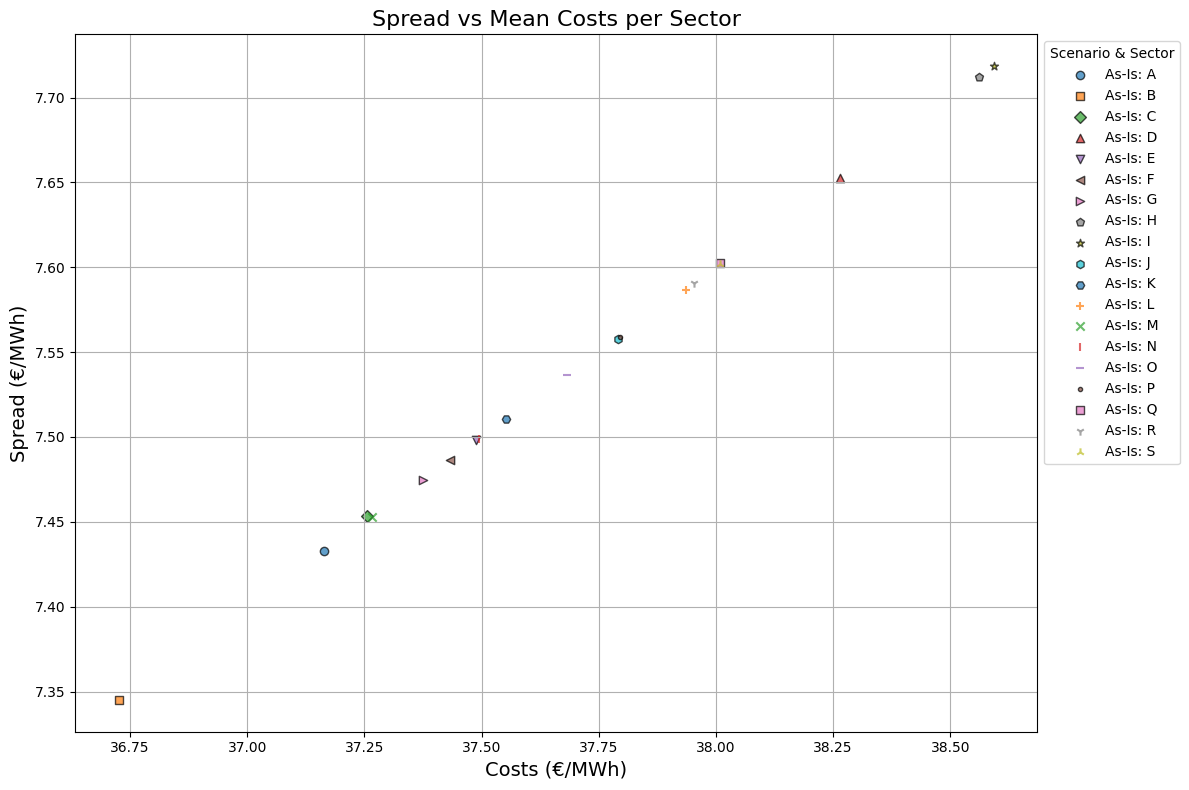

In [43]:
# Scatter-Plot erstellen
plt.figure(figsize=(12, 8))

# Definiere Marker und Farben für verschiedene Sektoren
sector_groups = spread_df['sector_group_id'].unique()
markers = [
    'o',  # Circle
    's',  # Square
    'D',  # Diamond
    '^',  # Upward triangle
    'v',  # Downward triangle
    '<',  # Leftward triangle
    '>',  # Rightward triangle
    'p',  # Pentagon
    '*',  # Star
    'h',  # Hexagon1
    'H',  # Hexagon2
    '+',  # Plus
    'x',  # Cross
    '|',  # Vertical line
    '_',  # Horizontal line
    '.',  # Point
    ',',  # Pixel
    '1',  # Tri-down (tripod down)
    '2',  # Tri-up (tripod up)
    '3'   # Tri-left (tripod left)
]
colors = plt.cm.tab10.colors  # Verschiedene Farben

# Plot für as-is
for i, sector in enumerate(sector_groups):
    sector_data = spread_df[spread_df['sector_group_id'] == sector]
    plt.scatter(
        sector_data['mean_cost'],
        sector_data['as_is_spread'],
        label=f"As-Is: {sector}",
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        alpha=0.7,
        edgecolor='black'
    )

# Achsen und Titel formatieren
plt.title('Spread vs Mean Costs per Sector', fontsize=16)
plt.xlabel('Costs (€/MWh)', fontsize=14)
plt.ylabel('Spread (€/MWh)', fontsize=14)
plt.legend(title='Scenario & Sector', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

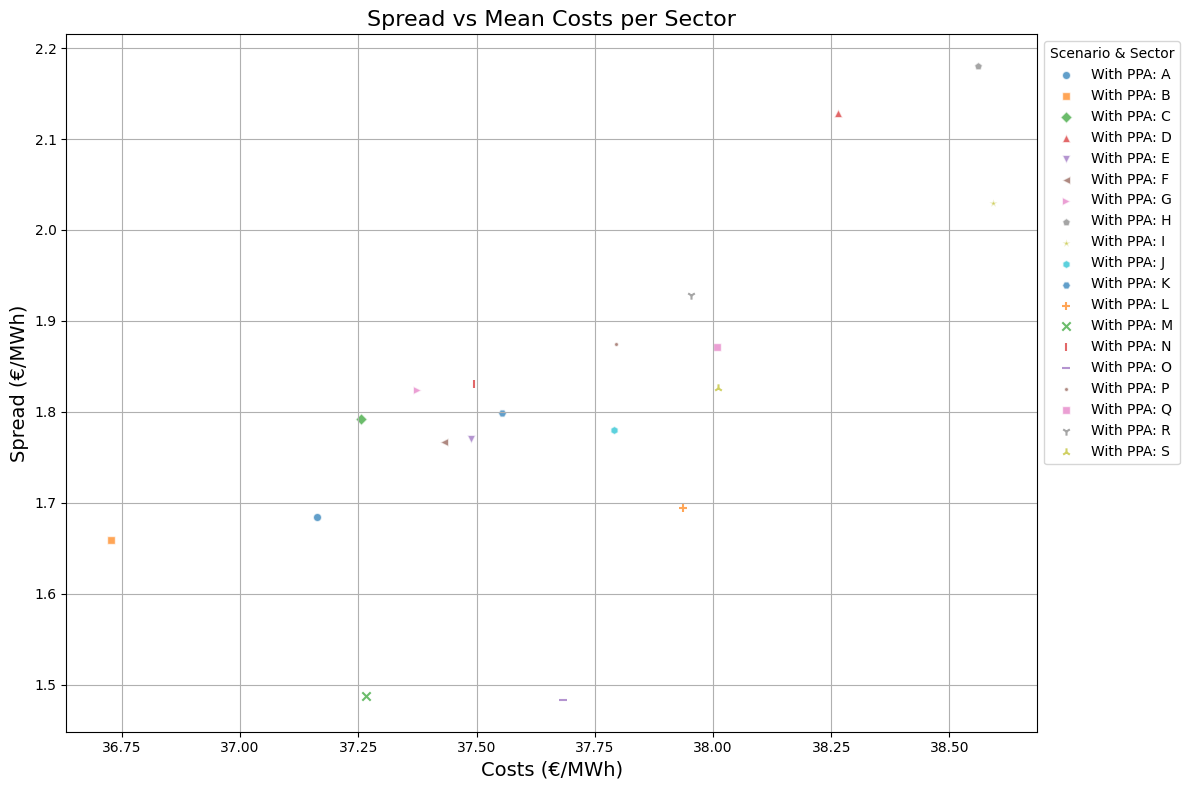

In [44]:
plt.figure(figsize=(12, 8))
for i, sector in enumerate(sector_groups):
    sector_data = spread_df[spread_df['sector_group_id'] == sector]
    plt.scatter(
        sector_data['mean_cost'],
        sector_data['with_ppa_spread'],
        label=f"With PPA: {sector}",
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        alpha=0.7,
        edgecolor='white'
    )
    
# Achsen und Titel formatieren
plt.title('Spread vs Mean Costs per Sector', fontsize=16)
plt.xlabel('Costs (€/MWh)', fontsize=14)
plt.ylabel('Spread (€/MWh)', fontsize=14)
plt.legend(title='Scenario & Sector', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

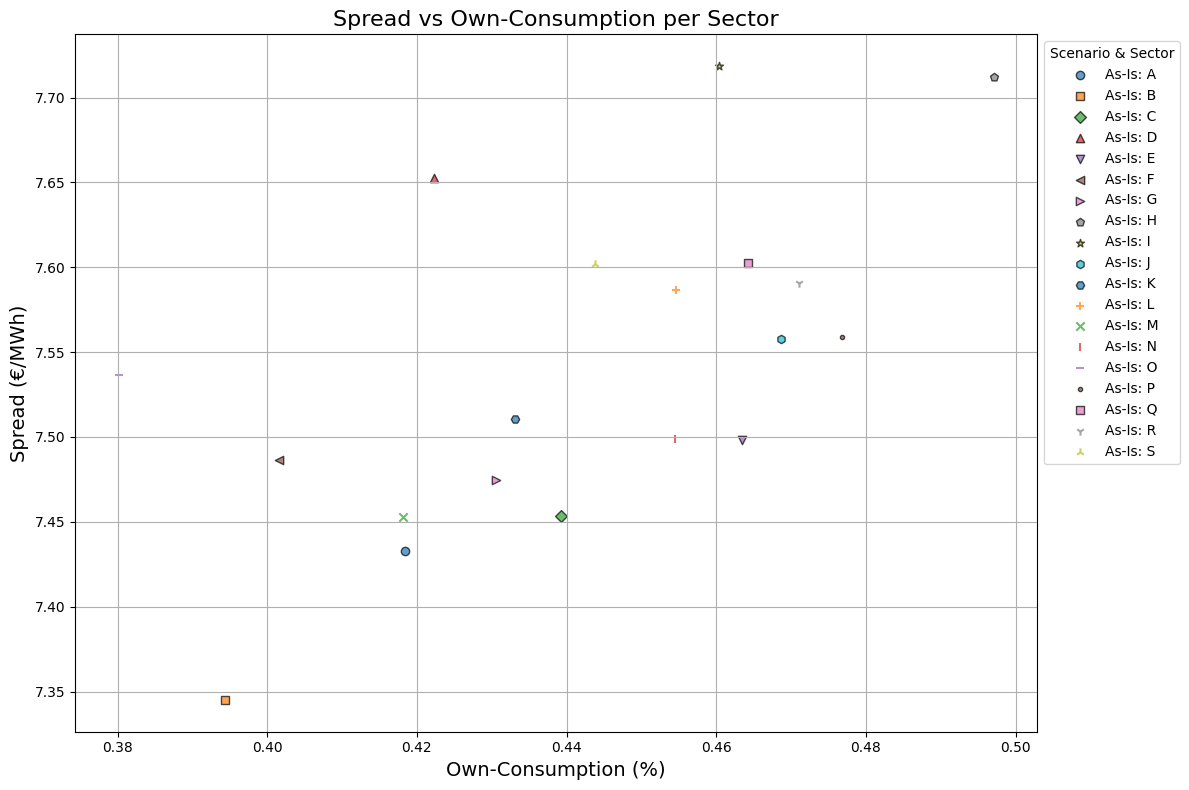

In [45]:
plt.figure(figsize=(12, 8))

for i, sector in enumerate(sector_groups):
    sector_data = spread_df[spread_df['sector_group_id'] == sector]
    plt.scatter(
        sector_data['own_consumption'],
        sector_data['as_is_spread'],
        label=f"As-Is: {sector}",
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        alpha=0.7,
        edgecolor='black'
    )

# Achsen und Titel formatieren
plt.title('Spread vs Own-Consumption per Sector', fontsize=16)
plt.xlabel('Own-Consumption (%)', fontsize=14)
plt.ylabel('Spread (€/MWh)', fontsize=14)
plt.legend(title='Scenario & Sector', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

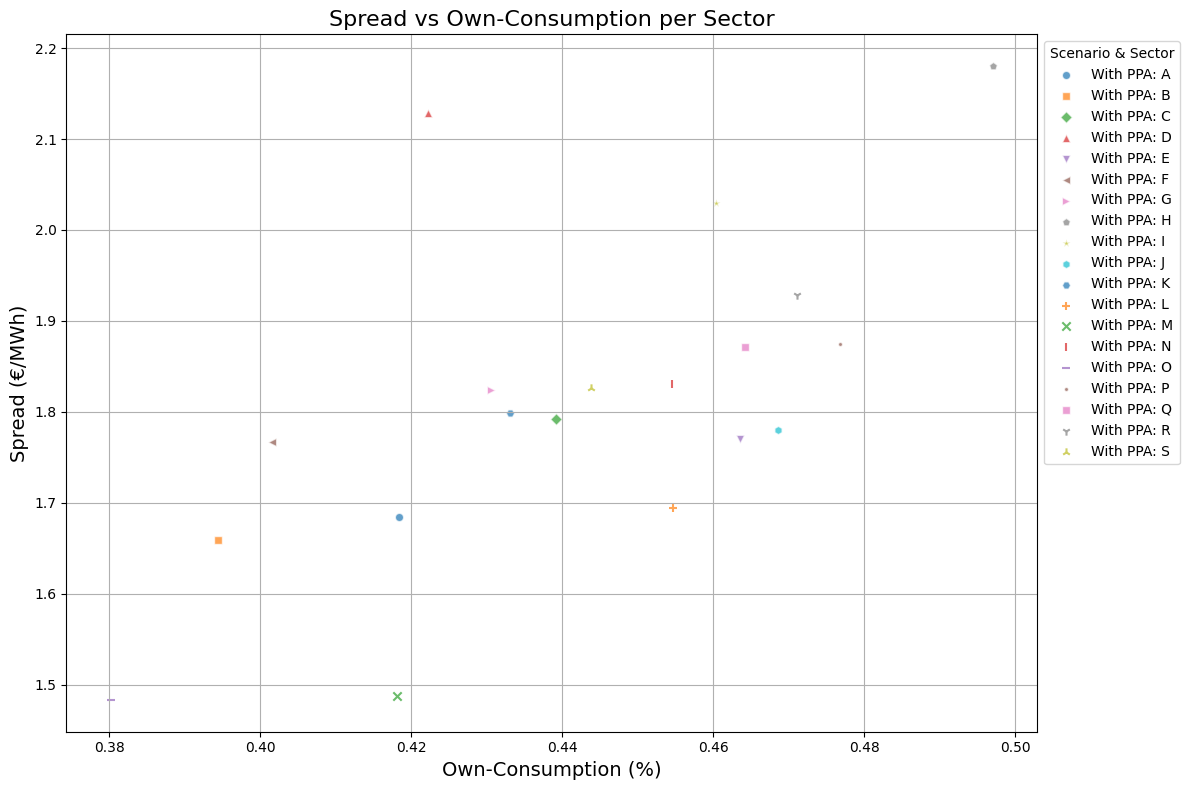

In [46]:
plt.figure(figsize=(12, 8))
for i, sector in enumerate(sector_groups):
    sector_data = spread_df[spread_df['sector_group_id'] == sector]
    plt.scatter(
        sector_data['own_consumption'],
        sector_data['with_ppa_spread'],
        label=f"With PPA: {sector}",
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        alpha=0.7,
        edgecolor='white'
    )
    
# Achsen und Titel formatieren
plt.title('Spread vs Own-Consumption per Sector', fontsize=16)
plt.xlabel('Own-Consumption (%)', fontsize=14)
plt.ylabel('Spread (€/MWh)', fontsize=14)
plt.legend(title='Scenario & Sector', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

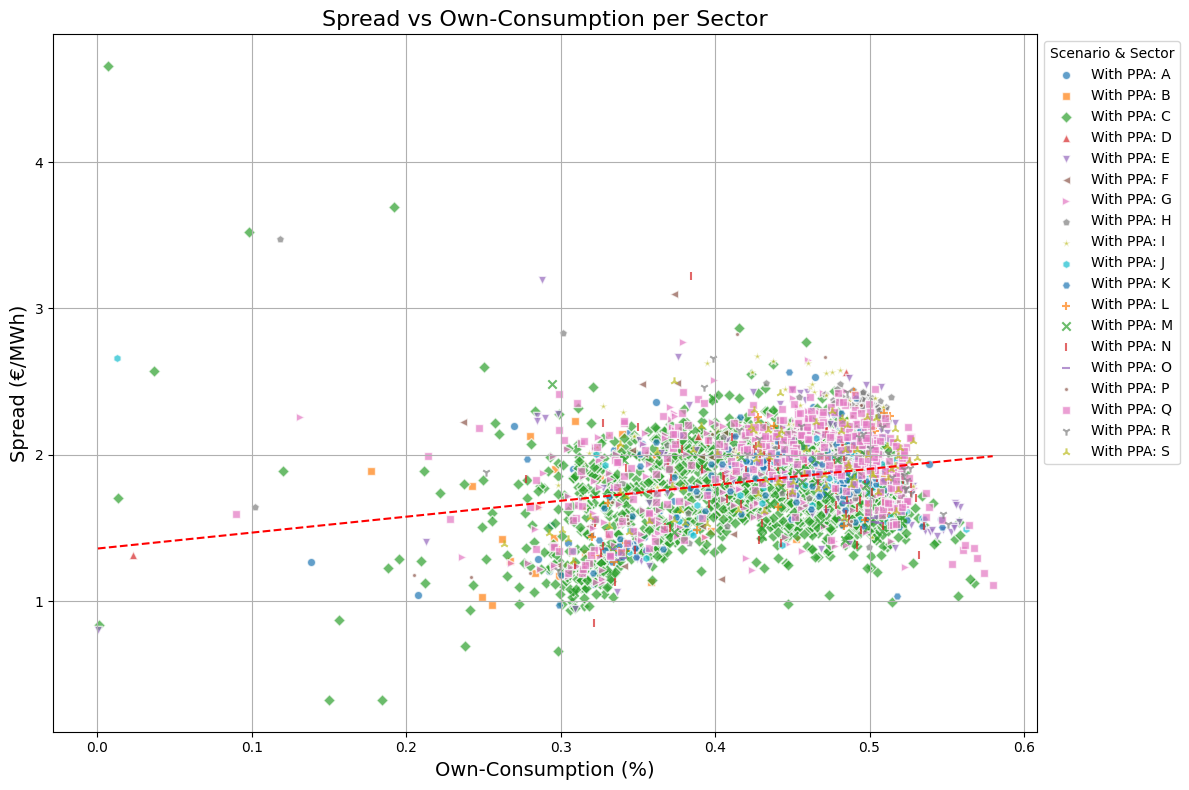

Regressionsgleichung: y = 1.0885x + 1.3591
Steigung: 1.0885
Achsenabschnitt: 1.3591


In [50]:
plt.figure(figsize=(12, 8))

# Alle Daten für die Regression sammeln
all_x = spread_df['own_consumption']
all_y = spread_df['with_ppa_spread']

# Lineare Regression durchführen
coefficients = np.polyfit(all_x, all_y, 1)  # Grad 1 für lineare Regression
regression_line = np.poly1d(coefficients)

# Scatter-Punkte für jede Sektorgruppe plotten
for i, sector in enumerate(sector_groups):
    sector_data = spread_df[spread_df['sector_group_id'] == sector]
    plt.scatter(
        sector_data['own_consumption'],
        sector_data['with_ppa_spread'],
        label=f"With PPA: {sector}",
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        alpha=0.7,
        edgecolor='white'
    )

# Regressionslinie plotten
x_line = np.linspace(all_x.min(), all_x.max(), 100)
plt.plot(x_line, regression_line(x_line), color='red', linestyle='--')

# Achsen und Titel formatieren
plt.title('Spread vs Own-Consumption per Sector', fontsize=16)
plt.xlabel('Own-Consumption (%)', fontsize=14)
plt.ylabel('Spread (€/MWh)', fontsize=14)
plt.legend(title='Scenario & Sector', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

# Regressionsdetails ausgeben
print(f"Regressionsgleichung: y = {coefficients[0]:.4f}x + {coefficients[1]:.4f}")
print(f"Steigung: {coefficients[0]:.4f}")
print(f"Achsenabschnitt: {coefficients[1]:.4f}")

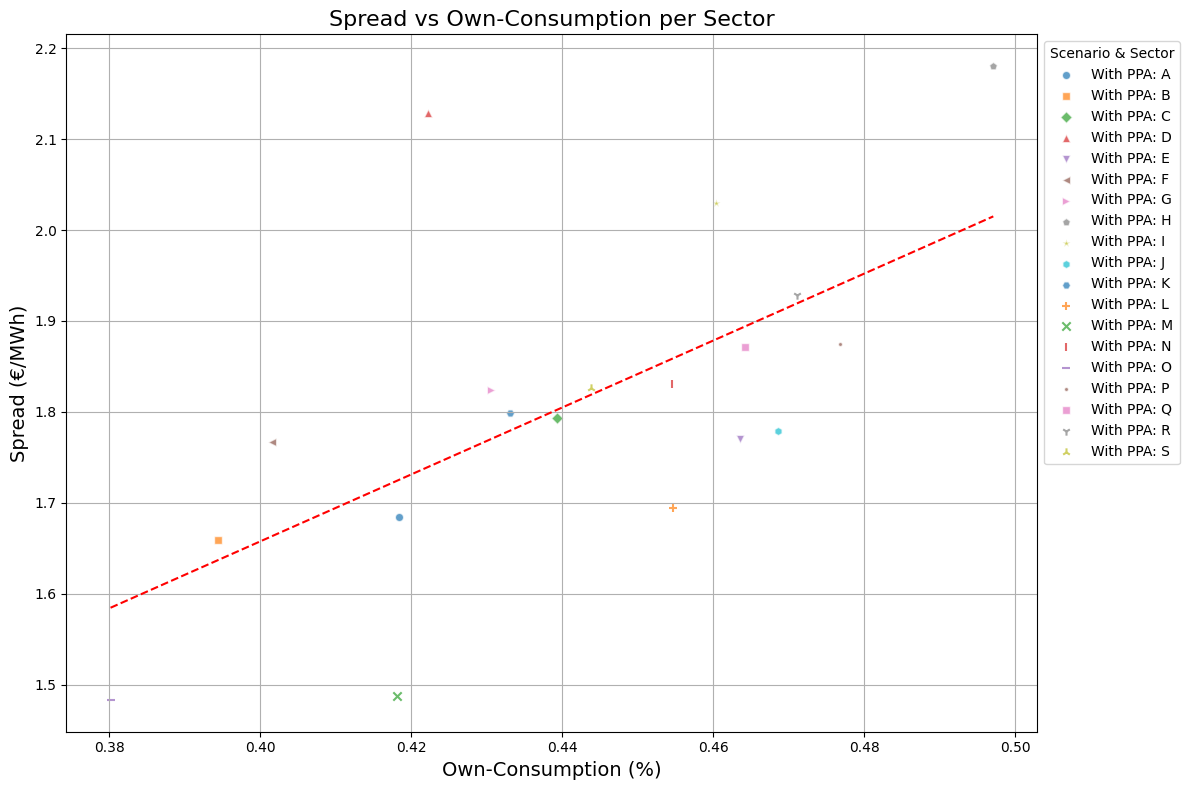

Regressionsgleichung: y = 3.6830x + 0.1844
Steigung: 3.6830
Achsenabschnitt: 0.1844


In [54]:
plt.figure(figsize=(12, 8))

# Alle Daten für die Regression sammeln
all_x = spread_df['own_consumption']
all_y = spread_df['with_ppa_spread']

# Lineare Regression durchführen
coefficients = np.polyfit(all_x, all_y, 1)  # Grad 1 für lineare Regression
regression_line = np.poly1d(coefficients)

# Scatter-Punkte für jede Sektorgruppe plotten
for i, sector in enumerate(sector_groups):
    sector_data = spread_df[spread_df['sector_group_id'] == sector]
    plt.scatter(
        sector_data['own_consumption'],
        sector_data['with_ppa_spread'],
        label=f"With PPA: {sector}",
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        alpha=0.7,
        edgecolor='white'
    )

# Regressionslinie plotten
x_line = np.linspace(all_x.min(), all_x.max(), 100)
plt.plot(x_line, regression_line(x_line), color='red', linestyle='--')

# Achsen und Titel formatieren
plt.title('Spread vs Own-Consumption per Sector', fontsize=16)
plt.xlabel('Own-Consumption (%)', fontsize=14)
plt.ylabel('Spread (€/MWh)', fontsize=14)
plt.legend(title='Scenario & Sector', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

# Regressionsdetails ausgeben
print(f"Regressionsgleichung: y = {coefficients[0]:.4f}x + {coefficients[1]:.4f}")
print(f"Steigung: {coefficients[0]:.4f}")
print(f"Achsenabschnitt: {coefficients[1]:.4f}")

# Nach Ort

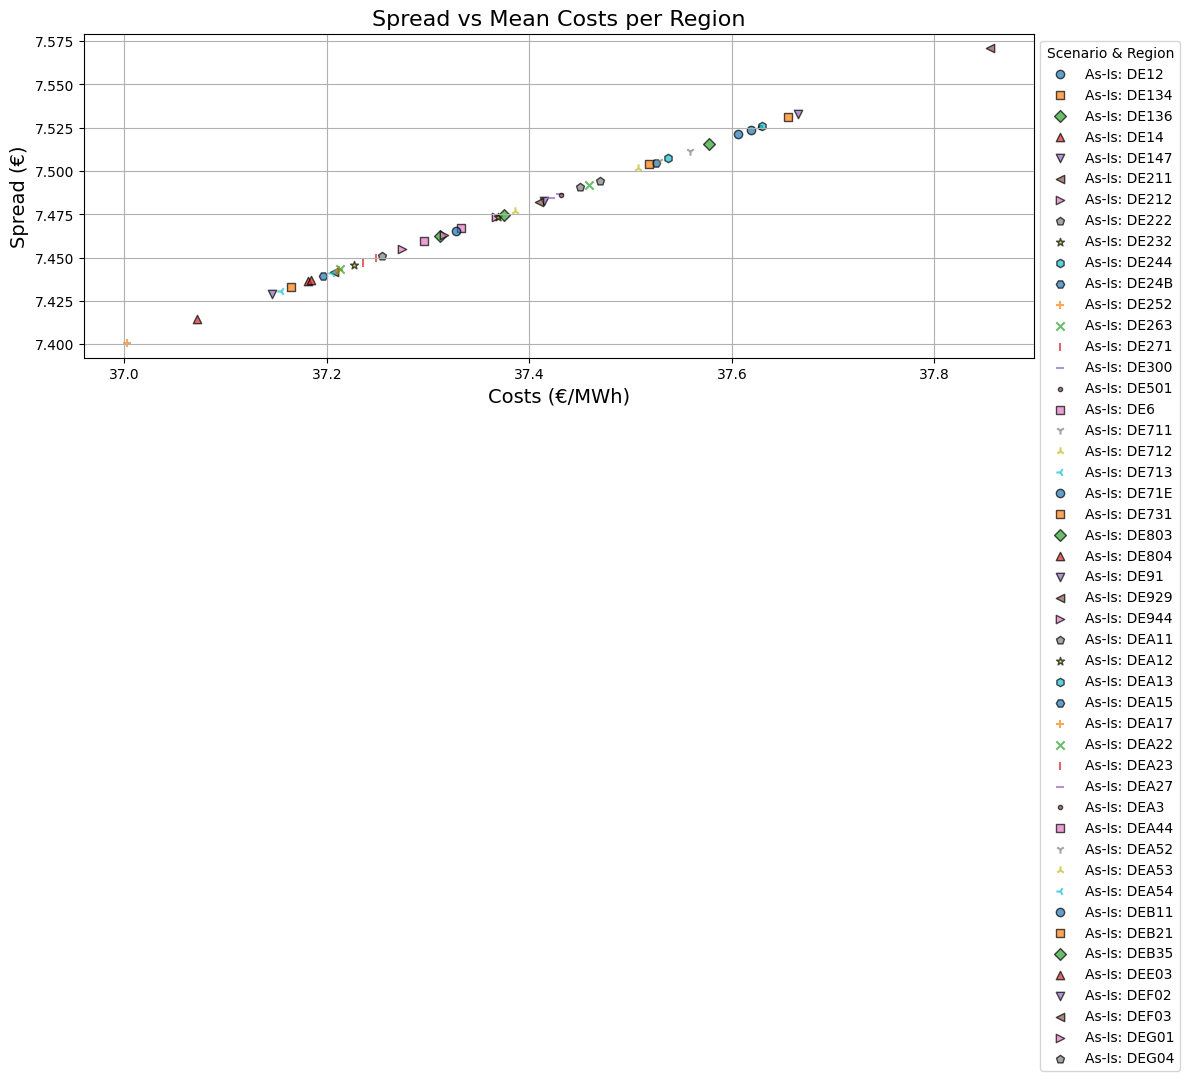

In [41]:
query = """
SELECT
    nuts_id,
    mean_cost,
    own_consumption * 100 AS own_consumption,
    "scenario_as_is_1.1" - "scenario_as_is_0.9" AS as_is_spread,
    "scenario_with_ppa_1.1" - "scenario_with_ppa_0.9" AS with_ppa_spread
FROM (
    SELECT
        nuts_id,
        SUM("scenario_as_is_1(€)") / NULLIF(SUM("load(mwh)"), 0) AS "mean_cost",
        SUM("scenario_as_is_0.9(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_as_is_0.9",
        SUM("scenario_as_is_1.1(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_as_is_1.1",
        SUM("scenario_with_ppa_0.9(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_with_ppa_0.9",
        SUM("scenario_with_ppa_1.1(€)") / NULLIF(SUM("load(mwh)"), 0) AS "scenario_with_ppa_1.1",
        (1 - (SUM("ppa_surplus(mwh)") / NULLIF(SUM("actual_power_needed_turbines(mwh)"), 0))) AS "own_consumption"
    FROM vea_results_timeseries.ppa_results
    GROUP BY nuts_id
) AS aggregated
GROUP BY nuts_id, mean_cost, own_consumption, as_is_spread, with_ppa_spread;
"""

# Abrufen der Daten (ersetzen Sie URI durch Ihre tatsächliche Verbindung)
spread_df = pd.read_sql(query, URI)
spread_df = spread_df.dropna()

# Scatter-Plot erstellen
plt.figure(figsize=(12, 8))

# Definiere Marker und Farben für verschiedene Sektoren
nuts_groups = spread_df['nuts_id'].unique()
markers = [
    'o',  # Circle
    's',  # Square
    'D',  # Diamond
    '^',  # Upward triangle
    'v',  # Downward triangle
    '<',  # Leftward triangle
    '>',  # Rightward triangle
    'p',  # Pentagon
    '*',  # Star
    'h',  # Hexagon1
    'H',  # Hexagon2
    '+',  # Plus
    'x',  # Cross
    '|',  # Vertical line
    '_',  # Horizontal line
    '.',  # Point
    ',',  # Pixel
    '1',  # Tri-down (tripod down)
    '2',  # Tri-up (tripod up)
    '3'   # Tri-left (tripod left)
]
colors = plt.cm.tab10.colors  # Verschiedene Farben

# Plot für as-is
for i, sector in enumerate(nuts_groups):
    sector_data = spread_df[spread_df['nuts_id'] == sector]
    plt.scatter(
        sector_data['mean_cost'],
        sector_data['as_is_spread'],
        label=f"As-Is: {sector}",
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        alpha=0.7,
        edgecolor='black'
    )

# Achsen und Titel formatieren
plt.title('Spread vs Mean Costs per Region', fontsize=16)
plt.xlabel('Costs (€/MWh)', fontsize=14)
plt.ylabel('Spread (€)', fontsize=14)
plt.legend(title='Scenario & Region', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

In [47]:
unique_nuts_ids = spread_df['nuts_id'].unique()
num_unique_nuts = len(unique_nuts_ids)
num_unique_nuts

48

In [48]:
plt.figure(figsize=(12, 8))

# Alle Daten für die Regression sammeln
all_x = spread_df['own_consumption']
all_y = spread_df['with_ppa_spread']

# Lineare Regression durchführen
coefficients = np.polyfit(all_x, all_y, 1)  # Grad 1 für lineare Regression
regression_line = np.poly1d(coefficients)

# Scatter-Punkte für jede Sektorgruppe plotten
for i, sector in enumerate(nuts_groups):
    sector_data = spread_df[spread_df['nuts_id'] == sector]
    plt.scatter(
        sector_data['own_consumption'],
        sector_data['with_ppa_spread'],
        label=f"With PPA: {sector}",
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        alpha=0.7,
        edgecolor='white'
    )

# Regressionslinie plotten
x_line = np.linspace(all_x.min(), all_x.max(), 100)
plt.plot(x_line, regression_line(x_line), color='red', linestyle='--')

# Achsen und Titel formatieren
plt.title('Spread vs Own-Consumption per Region', fontsize=16)
plt.xlabel('Own-Consumption (%)', fontsize=14)
plt.ylabel('Spread (€)', fontsize=14)
plt.legend(title='Scenario & Region', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

# Regressionsdetails ausgeben
print(f"Regressionsgleichung: y = {coefficients[0]:.4f}x + {coefficients[1]:.4f}")
print(f"Steigung: {coefficients[0]:.4f}")
print(f"Achsenabschnitt: {coefficients[1]:.4f}")

Regressionsgleichung: y = 0.0082x + 1.3929
Steigung: 0.0082
Achsenabschnitt: 1.3929


In [56]:
fig = px.scatter(
    spread_df,
    x="own_consumption",
    y="with_ppa_spread",
    color="nuts_id",  # Farbe basierend auf nuts_id
    hover_name="nuts_id",  # Zeigt NUTS ID beim Hover an
)

fig.update_layout(title="Interactive Scatter Plot: Spread vs Own-Consumption")
fig.show()

In [ ]:
# Visualisierung auf einer Karte von Deutschland
fig = px.scatter_mapbox(
    spread,
    lat="latitude",  # Spalte für Breitengrad
    lon="longitude",  # Spalte für Längengrad
    hover_name="nuts_id",  # NUTS-ID als Tooltip anzeigen
    hover_data=["difference_as_is", "difference_with_ppa"],  # Zusätzliche Informationen im Tooltip
    color="difference_with_ppa",  # Farbskala basierend auf einem Wert (z. B. Marktwert)
    mapbox_style="carto-positron",  # Stil der Karte (z. B. Carto Positron)
    zoom=4,  # Zoom-Level für Deutschland
    center={"lat": 51.1657, "lon": 10.4515}  # Zentrum der Karte (Deutschland)
)
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 700,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
# Karte anzeigen
fig.show(config=config)